# TEAM 25 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
#Gradient Color Bar Plots
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import RFE, RFECV
from pytorch_tabnet.tab_model import TabNetClassifier

from embedding_encoder import EmbeddingEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns= 100
import warnings
warnings.filterwarnings('ignore')

C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\AWWAL\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Helper Functions and Classes

In [4]:
def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        #zorder of 2 to get gradients above the facecolor, but below the bar outlines
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower',aspect="auto",zorder=2, norm=cm.colors.NoNorm(vmin=0,vmax=1),cmap=plt.get_cmap(cmap))

def get_weight_total_results(weights_dict):
    results_tot = pd.concat([pd.concat([key, pd.Series([val for i in range(4)], index=key.index)], axis=1) for val, key in weights_dict.items()], axis=0)
    results_tot.rename({0:'case'}, axis=1, inplace=True)

    train_scores = pd.concat([results_tot[['train', 'case']], pd.Series(['train' for i in range(len(results_tot))], index=results_tot.index)], axis=1)
    train_scores.rename({0:'split', 'train':'scores'}, axis=1, inplace=True)
    val_scores = pd.concat([results_tot[['val', 'case']], pd.Series(['val' for i in range(len(results_tot))], index=results_tot.index)], axis=1)
    val_scores.rename({0:'split', 'val':'scores'}, axis=1, inplace=True)
    test_scores = pd.concat([results_tot[['test', 'case']], pd.Series(['test' for i in range(len(results_tot))], index=results_tot.index)], axis=1)
    test_scores.rename({0:'split', 'test':'scores'}, axis=1, inplace=True)

    results_tot = pd.concat([train_scores, val_scores, test_scores], axis=0).reset_index()
    #results_tot = results_tot[results_tot.index!='low'].reset_index()
    
    return results_tot        

        
def get_results_list(row, results):
    res = []
    for model, result in results.items():
        for col in ['train', 'val', 'test']:
                res.append([model, result.loc[row, col], col])
    return pd.DataFrame(res, columns=['model', 'score', 'split'])
        
class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 num_cols, 
                 cat_ohe_cols, 
                 #cat_high_cols,
                 cat_non_ohe_cols=[], 
                 imputer=SimpleImputer(strategy='most_frequent'),
                 scaler=StandardScaler(),
                 ohe=OneHotEncoder(handle_unknown='ignore'),
                 #embedder=EmbeddingEncoder(task="classification")
                 ):
   
        self.num_cols = num_cols
        self.cat_ohe_cols = cat_ohe_cols
        #self.cat_high_cols = cat_high_cols
        self.cat_non_ohe_cols = cat_non_ohe_cols
        self.imputer = imputer
        self.scaler = scaler
        self.ohe = ohe if self.cat_ohe_cols else False
        #self.embedder= embedder if self.cat_high_cols else False
        self.numerical_pipeline = Pipeline(steps=[('scaler', self.scaler)])
        self.categorical_pipeline = Pipeline(steps=[('ohe', self.ohe)])
        if self.ohe:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols),
                                                   ('cat', self.categorical_pipeline, cat_ohe_cols)],
                                     remainder='passthrough')
        else:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols)],
                                 remainder='passthrough')
        
    def fit(self, X, y=None):
        self.preprocessor.fit(X)
        if self.ohe:
            self.cat_cols_name = list(self.preprocessor.transformers_[1][1]['ohe'].get_feature_names(self.cat_ohe_cols))
        else:
            self.cat_cols_name = []
        return self
    
    def transform(self, X, y=None):
        
        X = pd.DataFrame(self.preprocessor.transform(X), columns=self.num_cols+self.cat_cols_name+self.cat_non_ohe_cols)
        return X
        
#     def ocptn_fe(self, X, y, test=False):
#         if not test:
#             pd.concat([X['OCPTN_NM'], y.reset_index(drop=True)], axis=1).groupby()
 
#         return X

def get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols,
             n_folds=10,
             model_type='Catboost'):

    temp = data.copy()
    
    if cat_non_ohe_cols:
        for col in cat_non_ohe_cols:
            label_encoder = LabelEncoder()
            temp[col] = label_encoder.fit_transform(temp[col])


    temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA'], axis=1, inplace=True)
    try:
        temp['OCPTN_NM'] = temp['OCPTN_NM'].fillna(temp['OCPTN_NM'].mode()[0]).astype(int)
    except:
        pass

    X = temp.drop('RISK', axis=1)
    y = temp['RISK']


    target_mapping = {'low':0, 'medium':1, 'high':2}
    y = y.map(target_mapping)

    skf = StratifiedKFold(n_splits=n_folds, random_state=None, shuffle=False)
    
    fold_dict = dict()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)


        preprocessor = PreprocessData(num_cols=num_cols, 
                                   cat_ohe_cols=cat_ohe_cols, 
                                   cat_non_ohe_cols=cat_non_ohe_cols)
     
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        X_test = preprocessor.transform(X_test)
        
        if model_type == 'Catboost':
            for col in cat_non_ohe_cols:
                try:
                    X_train[col] = X_train[col].astype(int)
                    X_val[col] = X_val[col].astype(int)
                    X_test[col] = X_test[col].astype(int)
                except:
                    pass
        
#         else:
#             try:
#             X_train.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_val.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_test.drop(['OCPTN_NM'], axis=1, inplace=True)
        
        fold_dict[f'fold_{i+1}'] = X_train, X_val, X_test, y_train, y_val, y_test
         
    return fold_dict

def run_model(model, fold_dict, kwargs=None, get_total_results=False):
    f1_scores_train=[]
    f1_scores_val=[]
    f1_scores_test=[]
    mcc = []
    for fold, dataset in fold_dict.items():
        X_train, X_val, X_test, y_train, y_val, y_test = dataset
        if kwargs is not None:
            try:
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
            except:
                X_train, X_val, X_test, y_train, y_val, y_test = X_train.values, X_val.values, X_test.values, y_train.values, y_val.values, y_test.values
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        else:
            model.fit(X_train, y_train)
        y_train_preds = model.predict(X_train)
        y_val_preds = model.predict(X_val)
        y_test_preds = model.predict(X_test)
        f1_scores_train.append(f1_score(y_train, y_train_preds, average=None))
        f1_scores_val.append(f1_score(y_val, y_val_preds, average=None))
        f1_scores_test.append(f1_score(y_test, y_test_preds, average=None))
        mcc.append([matthews_corrcoef(y_train, y_train_preds), 
                    matthews_corrcoef(y_val, y_val_preds), 
                    matthews_corrcoef(y_test, y_test_preds)])
        
    train_f1 = np.array(f1_scores_train).mean(axis=0)
    val_f1 = np.array(f1_scores_val).mean(axis=0)
    test_f1 = np.array(f1_scores_test).mean(axis=0)
    mcc = np.array(mcc).mean(axis=0)
    results = pd.DataFrame(np.vstack([np.array([train_f1, val_f1, test_f1]).T, mcc]), 
                 columns=['train', 'val', 'test'], 
                 index=['low', 'medium', 'high', 'mcc'])
    if get_total_results:
        return results, f1_scores_train, f1_scores_val, f1_scores_test, mcc
    else:
        return results

def feature_drop_scorer(rfe, fold_dict, model):
    max_rank = np.max(rfe.ranking_)
    mean_scores_train = []
    std_scores_train = []
    mean_scores_val = []
    std_scores_val = []
    mean_scores_test = []
    std_scores_test = []
    for i in tqdm.tqdm(range(max_rank+1, 1, -1)):

        scores_train = []
        scores_val = []
        scores_test = []
        for fold, dataset in fold_dict.items():
            X_train, y_train = dataset[0].loc[:, rfe.ranking_ < i], dataset[3]
            X_val, y_val = dataset[1].loc[:, rfe.ranking_ < i], dataset[4]
            X_test, y_test = dataset[2].loc[:, rfe.ranking_ < i], dataset[5]

            model.fit(X_train, y_train)
            y_train_preds = model.predict(X_train)
            y_val_preds = model.predict(X_val)
            y_test_preds = model.predict(X_test)
            scores_val.append(matthews_corrcoef(y_val, y_val_preds))
            scores_train.append(matthews_corrcoef(y_train, y_train_preds))
            scores_test.append(matthews_corrcoef(y_test, y_test_preds))

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
        mean_score_test = np.mean(scores_test)
        std_score_test = np.std(scores_test)
        mean_scores_test.append(mean_score_test)
        std_scores_test.append(std_score_test)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test

def get_features(rfe, X, features_required):
    max_rank = np.max(rfe.ranking_)
    for i in range(max_rank+1, 1, -1):
        cols = X.loc[:, rfe.ranking_ < i].columns
        if len(cols) == features_required:
            return cols
        
    return 'Please enter a valid feature number as per combination searched.'

def calculate_cat_col(df):
    cat_cols = []
    for i, col in enumerate(df.columns):
        if col in cat_non_ohe_cols:
            cat_cols.append(i)
    return cat_cols

class GreedyFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, X, y, X_val, y_val, model, fit_kwargs=None):
        self.X = X
        self.y = y
        self.X_val = X_val
        self.y_val = y_val
        self.model = model
        self.fit_kwargs = fit_kwargs
        
    def fit(self):

        self.cols_selected = ['WIRES_SUM_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_OUT']
        cols = list(set(list(self.X.columns))-set(self.cols_selected))
        for _ in tqdm.tqdm(range(len(self.X.columns)-len(self.cols_selected))):
            score = []
            for col in cols:
                combination_to_score = [col] + self.cols_selected
                X = self.X.loc[:, combination_to_score]
                X_val = self.X_val.loc[:, combination_to_score]
                if self.fit_kwargs:
                    
                    if calculate_cat_col(X):
                        self.fit_kwargs['cat_features'] = calculate_cat_col(X)
                    
                    self.model.fit(X, self.y, eval_set=[(X_val, self.y_val)], **self.fit_kwargs)
                    try:
                        self.fit_kwargs.pop('cat_features')
                    except:
                        pass
                    
                else:
                    self.model.fit(X, self.y)
                y_train_preds = self.model.predict(X)
                y_val_preds = self.model.predict(X_val)
                score.append(matthews_corrcoef(self.y_val, y_val_preds))
                
                
            self.cols_selected.append(cols[np.argmax(score)])
            cols.pop(np.argmax(score))
        
    def transform(self, X, top_k):
        return X.loc[:, self.cols_selected[:top_k]]

In [6]:
nodes = pd.read_csv('UofT_nodes.csv')
occupation_risk = pd.read_csv('UofT_occupation_risk.csv').set_index('code')['occupation_risk']

nodes['OCPTN_RISK'] = nodes['OCPTN_NM'].map(occupation_risk)

nodes['BIRTH_DT'] = pd.to_datetime(nodes['BIRTH_DT'])
nodes['CUST_ADD_DT'] = pd.to_datetime(nodes['CUST_ADD_DT'])

nodes['CUST_YEARS'] = 2022 - nodes['CUST_ADD_DT'].dt.year
nodes['AGE'] = 2022 - nodes['BIRTH_DT'].dt.year

# df_edges = pd.read_csv('UofT_edges.csv')
# graph_nodes = list(set(np.hstack([df_edges['source'].values, df_edges['target'].values])))
# nodes = nodes[nodes['CUSTOMER_ID'].isin(graph_nodes)]
#data_dictionary = pd.read_excel('Data dictionry (1).xlsx')
#nodes.columns = data_dictionary.iloc[:, 1][data_dictionary.iloc[:, 0].isin(nodes.columns)]

In [7]:
nodes.nunique()

BIRTH_DT                    37388
CUST_ADD_DT                 19411
OCPTN_NM                      682
RES_CNTRY_CA                    2
CNTRY_OF_INCOME_CA              2
PEP_FL                          2
CASH_SUM_IN                715336
CASH_CNT_IN                    79
CASH_SUM_OUT               712608
CASH_CNT_OUT                  194
WIRES_SUM_IN               707903
WIRES_CNT_IN                  530
WIRES_SUM_OUT              669853
WIRES_CNT_OUT                 917
COUNTRY_RISK_INCOME             3
COUNTRY_RISK_RESIDENCY          3
RISK                            3
NAME                       995518
GENDER                          2
CUSTOMER_ID               1000000
OCPTN_RISK                      3
CUST_YEARS                     72
AGE                           130
dtype: int64

### Missing values

In [42]:
missing_values = nodes.isna().sum()
missing_values = missing_values[missing_values!=0].sort_values(ascending=False)

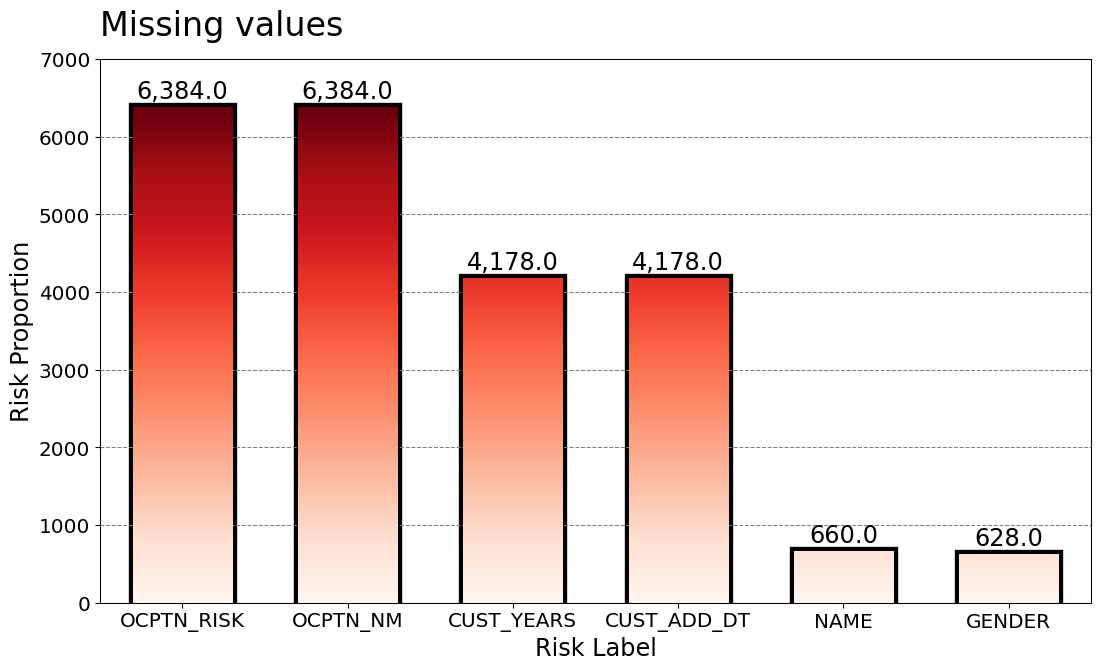

In [206]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax = plt.gca()
bar1 = ax.bar(x = missing_values.index, height = missing_values, width=0.6, edgecolor='k', linewidth=7)
ax.bar_label(bar1, labels=[f'{e:,.1f}' for e in missing_values], padding=3, color='black', fontsize=18)
gradientbars(bar1, missing_values.values, 'Reds')


plt.ylabel('Risk Proportion', fontsize=18)
plt.yticks(fontsize=15)
plt.title('Missing values', fontsize=25, loc='left', y=1.03)

plt.xlabel('Risk Label', fontsize=18)
plt.xticks(fontsize=15)
plt.axis([-0.5, 5.5, 0, 7000])
ax.grid(which='major', axis='y', linestyle='--', color='gray', zorder=0)
plt.show()

### Target ratios

In [280]:
risk_ratios = (nodes['RISK'].value_counts()/len(nodes)) * 100

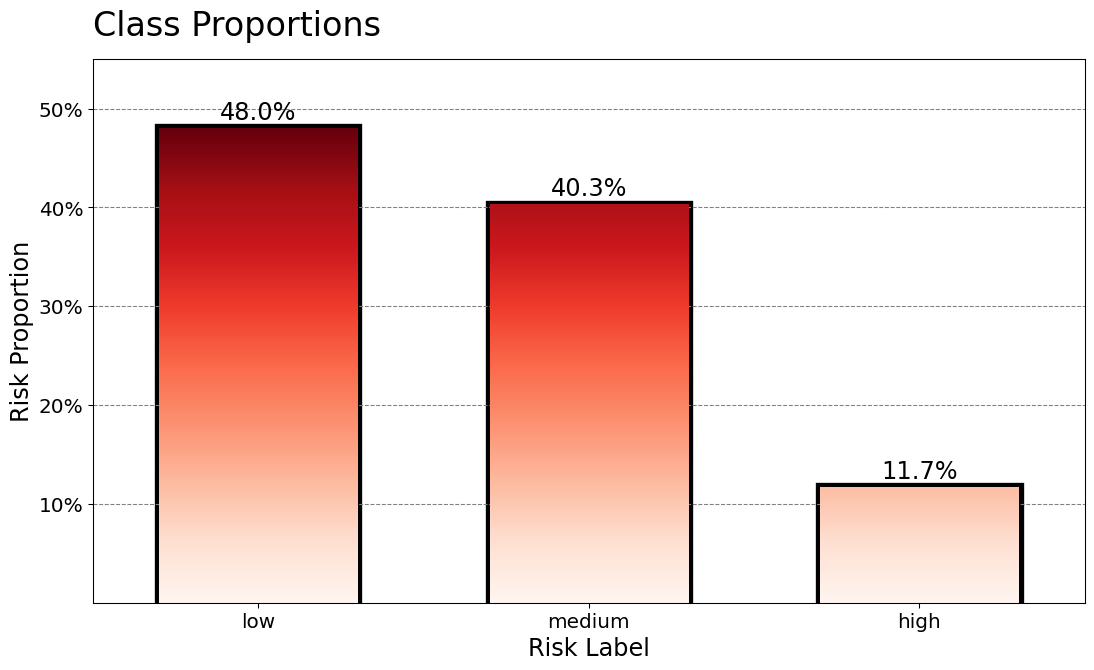

In [282]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax = plt.gca()
bar1 = ax.bar(x = risk_ratios.index, height = risk_ratios, width=0.6, edgecolor='k', linewidth=7)
ax.bar_label(bar1, labels=[f'{e:,.1f}%' for e in risk_ratios], padding=3, color='black', fontsize=18)
gradientbars(bar1, risk_ratios.values, 'Reds')


plt.ylabel('Risk Proportion', fontsize=18)
plt.yticks([i*10 for i in range(1, 7)], labels=[f'{i*10}%' for i in range(1, 7)], fontsize=15)
plt.title('Class Proportions', fontsize=25, y=1.03, loc='left')
plt.xlabel('Risk Label', fontsize=18)
plt.xticks(fontsize=15)
plt.axis([-0.5, 2.5, 0, 55])
ax.grid(which='major', axis='y', linestyle='--', color='gray', zorder=0)
plt.show()

# Feature Selection

In [46]:
chi_cat_cols = ['RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'GENDER', 'OCPTN_RISK']

X = nodes.drop('RISK',axis=1)[chi_cat_cols]
y = nodes['RISK']

In [47]:
label_encoder = LabelEncoder()
for col in chi_cat_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [48]:
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

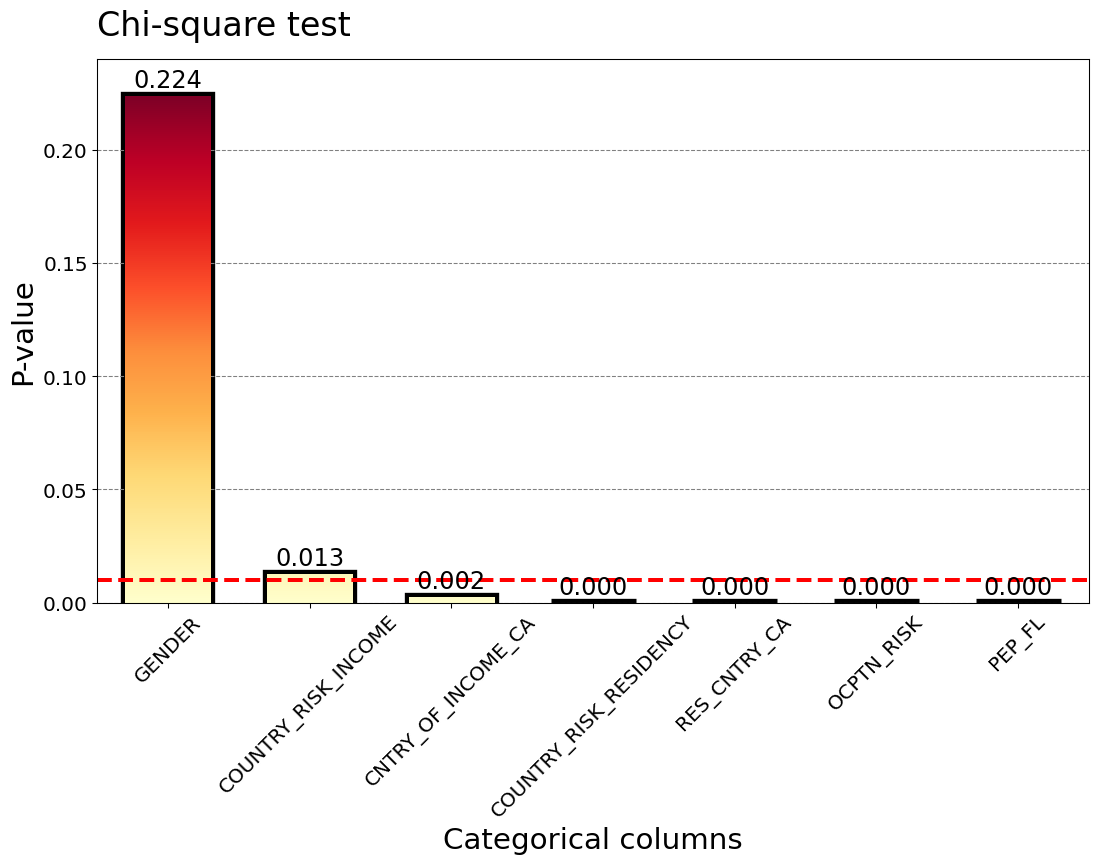

In [209]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax = plt.gca()
bar1 = ax.bar(x = p_values.index, height = p_values, width=0.6, edgecolor='k', linewidth=7)
ax.bar_label(bar1, labels=[f'{e:,.3f}' for e in p_values], padding=3, color='black', fontsize=18)
gradientbars(bar1, p_values.values, 'YlOrRd')


plt.ylabel('P-value', fontsize=22)
#plt.yticks([i*10 for i in range(1, 7)], labels=[f'{i*10}%' for i in range(1, 7)], fontsize=18)

plt.hlines(0.01, -0.5, 6.5, colors='r', linestyle='--', linewidth=3)
plt.title('Chi-square test', fontsize=25, y=1.03, loc='left')
plt.xlabel('Categorical columns', fontsize=22)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.axis([-0.5, 6.5, 0, 0.24])
ax.grid(which='major', axis='y', linestyle='--', color='gray', zorder=0)
plt.show()

## Greedy Feature Selection

In [28]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']#, 'degree', 'closeness_centrality',
           #'subgraph_size', 'sent', 'received', 'node_sg_degree_frac', 'diameter_len_frac', 'money_displaced_len_frac']#, 'subgraphs_avg_money_sent','subgraphs_avg_money_received']
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'GENDER', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'CUSTOMER_ID', 'NAME', 'RISK']
data = nodes[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
imputer = SimpleImputer(strategy='most_frequent')
temp = imputer.fit_transform(data)
data = pd.DataFrame(temp, columns=data.columns)
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols,
             n_folds=10)
popped = fold_dict.pop(f'fold_{len(fold_dict)}', None)

In [47]:
gfs = GreedyFeatureSelection(fold_dict['fold_1'][0], 
                              fold_dict['fold_1'][3],
                              fold_dict['fold_1'][1],
                              fold_dict['fold_1'][4],
                              model=CatBoostClassifier(eval_metric="MCC", task_type="GPU"),
                              fit_kwargs={'early_stopping_rounds':50, 
                                          'verbose':0})
gfs.fit()

 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [09:18<01:59, 39.86s/it]


ValueError: attempt to get argmax of an empty sequence

In [51]:
gfs.cols_selected

['WIRES_SUM_IN',
 'CASH_SUM_OUT',
 'CASH_CNT_OUT',
 'WIRES_SUM_OUT',
 'WIRES_CNT_OUT',
 'CUST_YEARS',
 'WIRES_CNT_IN',
 'OCPTN_NM',
 'AGE',
 'CASH_SUM_IN',
 'CASH_CNT_IN',
 'PEP_FL',
 'OCPTN_RISK',
 'COUNTRY_RISK_RESIDENCY',
 'COUNTRY_RISK_INCOME',
 'GENDER',
 'RES_CNTRY_CA',
 'CNTRY_OF_INCOME_CA']

In [66]:
def greedy_feature_scorer(cols, fold_dict, model, fit_kwargs=None):
    init_cols = ['WIRES_SUM_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_OUT']
    mean_scores_train = []
    std_scores_train = []
    mean_scores_val = []
    std_scores_val = []
    mean_scores_test = []
    std_scores_test = []
    for i in tqdm.tqdm(range(len(cols)+1)):

        scores_train = []
        scores_val = []
        scores_test = []
        for fold, dataset in fold_dict.items():
            X_train, y_train = dataset[0].loc[:, init_cols+cols[:i]], dataset[3]
            X_val, y_val = dataset[1].loc[:, init_cols+cols[:i]], dataset[4]
            X_test, y_test = dataset[2].loc[:, init_cols+cols[:i]], dataset[5]
            if fit_kwargs:
                    
                if calculate_cat_col(X_train):
                    fit_kwargs['cat_features'] = calculate_cat_col(X_train)

                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **fit_kwargs)
                try:
                    self.fit_kwargs.pop('cat_features')
                except:
                    pass
            
            y_train_preds = model.predict(X_train)
            y_val_preds = model.predict(X_val)
            y_test_preds = model.predict(X_test)
            scores_val.append(matthews_corrcoef(y_val, y_val_preds))
            scores_train.append(matthews_corrcoef(y_train, y_train_preds))
            scores_test.append(matthews_corrcoef(y_test, y_test_preds))

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
        mean_score_test = np.mean(scores_test)
        std_score_test = np.std(scores_test)
        mean_scores_test.append(mean_score_test)
        std_scores_test.append(std_score_test)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test

In [67]:
mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test = greedy_feature_scorer(gfs.cols_selected[4:], 
                      fold_dict, 
                      CatBoostClassifier(eval_metric="MCC", task_type="GPU"),
                      fit_kwargs={'early_stopping_rounds':50, 
                                  'verbose':0})

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [13:52<00:00, 55.53s/it]


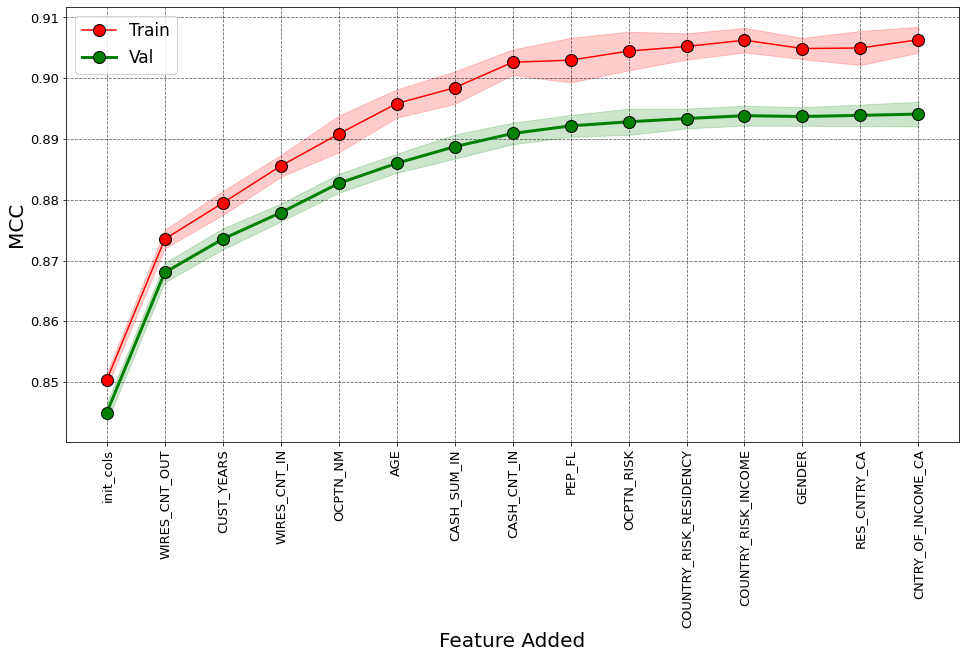

In [119]:
upper_bound_train = np.array(mean_scores_train) + np.array(std_scores_train)
lower_bound_train = np.array(mean_scores_train) - np.array(std_scores_train)
upper_bound_val = np.array(mean_scores_val) + np.array(std_scores_val)
lower_bound_val = np.array(mean_scores_val) - np.array(std_scores_val)

plt.figure(figsize=(16, 8))
plt.plot(mean_scores_train, '-o', label='Train', color='r', linewidth=1.5, markersize=12, mec='k')
plt.plot(mean_scores_val, '-o', label='Val', color='g', linewidth=3, markersize=12, mec='k')
plt.fill_between(range(0, 15, 1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(0, 15, 1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.xticks(ticks=range(0, 15, 1), labels=['init_cols']+gfs.cols_selected[4:], fontsize=13, rotation=90)
plt.yticks(fontsize=13)
plt.ylabel('MCC', fontsize=20)
plt.xlabel('Feature Added', fontsize=20)
plt.legend(fontsize=17)
plt.show()
#'-o', linewidth=5, markersize=12, mec='k'

**inferences**:
* as the number of feature increases difference between training and validation scores increases.
* after a certain point, No new exposure of target signal is achieved in the data while the confusion and ability to overfit keep on increasing because of increased not needed variance and higher dimensionality of the dataset.
* OCPTN_NM is better than OCPTN_RISK.

### Visualizing the data

In [15]:
cols_to_visualize = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT',
       'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT',
       'CUST_YEARS', 'AGE', 'PEP_FL_0.0', 'PEP_FL_1.0',
       'OCPTN_RISK_High', 'OCPTN_RISK_Low', 'OCPTN_RISK_Moderate']
X = fold_dict['fold_1'][0][cols_to_visualize]

In [16]:
pca = PCA()
pca.fit(X)

PCA()

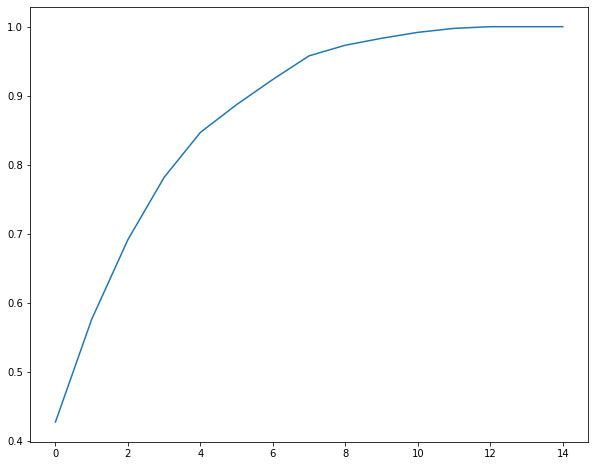

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [18]:
pca = PCA(n_components=11)
X_pca  =pca.fit_transform(X)

In [20]:
x = np.vstack([X_pca[fold_dict['fold_1'][3]==0][:10000], X_pca[fold_dict['fold_1'][3]==1][:10000], X_pca[fold_dict['fold_1'][3]==2][:10000]])
y = np.hstack([fold_dict['fold_1'][3][fold_dict['fold_1'][3]==0][:10000], fold_dict['fold_1'][3][fold_dict['fold_1'][3]==1][:10000], fold_dict['fold_1'][3][fold_dict['fold_1'][3]==2][:10000]])

tsne = TSNE()
X_train_tsne = tsne.fit_transform(x)

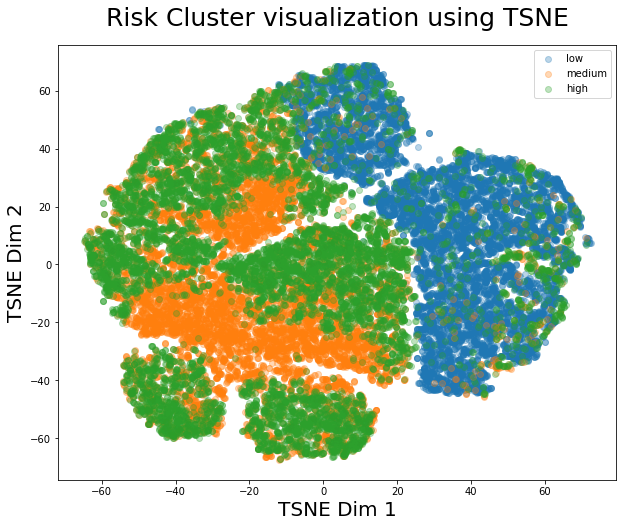

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[y==0][:, 0], X_train_tsne[y==0][:, 1], label='low', alpha=0.3)
plt.scatter(X_train_tsne[y==1][:, 0], X_train_tsne[y==1][:, 1], label='medium', alpha=0.3)
plt.scatter(X_train_tsne[y==2][:, 0], X_train_tsne[y==2][:, 1], label='high', alpha=0.3)
plt.xlabel('TSNE Dim 1', fontsize=20)
plt.ylabel('TSNE Dim 2', fontsize=20)
plt.title('Risk Cluster visualization using TSNE', fontsize=25, y=1.03)
plt.legend()
plt.show()

## Missing values

Missing values imputation is very important has to be done in a way that we can get the best possible classification metric score specifically for those values which had missing values.

* We have to find methods which make sure that the missing values when imputed help us get the highest classification metric.

In [41]:
nodes.isna().sum()

BIRTH_DT                     0
CUST_ADD_DT               1470
OCPTN_NM                  2317
RES_CNTRY_CA                 0
CNTRY_OF_INCOME_CA           0
PEP_FL                       0
CASH_SUM_IN                  0
CASH_CNT_IN                  0
CASH_SUM_OUT                 0
CASH_CNT_OUT                 0
WIRES_SUM_IN                 0
WIRES_CNT_IN                 0
WIRES_SUM_OUT                0
WIRES_CNT_OUT                0
COUNTRY_RISK_INCOME          0
COUNTRY_RISK_RESIDENCY       0
RISK                         0
NAME                       245
GENDER                     238
CUSTOMER_ID                  0
dtype: int64

### Which occupation has highest risk factor?



Possibilities:

* Risk proportion vectors
* target encoding
* combine small jobs into "other" just on the basis of counts or specifically combine high,medium,low less frequency jobs together.

In [157]:
ocptn_grt_10 = nodes['OCPTN_NM'].value_counts()
ocptn_grt_10 = ocptn_grt_10[ocptn_grt_10 > 100]
nodes[nodes['OCPTN_NM'].isin(ocptn_grt_10.index)]['OCPTN_NM'].nunique()

255

In [158]:
ocptn_grt_10_df = nodes[nodes['OCPTN_NM'].isin(ocptn_grt_10.index)]

In [104]:
temp = ocptn_grt_10_df.groupby('OCPTN_NM').apply(lambda df:df['RISK'].value_counts()/len(df))
temp = temp.reset_index()
ocptn_nm_map = nodes['OCPTN_NM'].value_counts()
temp['OCPTN_NM_count'] = temp['OCPTN_NM'].map(ocptn_nm_map)
temp_low = temp[temp['level_1'] == 'low']
temp_medium = temp[temp['level_1'] == 'medium']
temp_high = temp[temp['level_1'] == 'high']

In [109]:
temp_medium.sort_values('RISK').iloc[-60:]

,OCPTN_NM,level_1,RISK,OCPTN_NM_count
441,603.0,medium,0.772727,198
406,556.0,medium,0.773723,411
306,397.0,medium,0.777778,198
35,49.0,medium,0.782609,207
288,370.0,medium,0.792035,226
620,839.0,medium,0.793427,213
345,464.0,medium,0.796482,398
252,332.0,medium,0.811828,186
91,131.0,medium,0.813051,567
282,359.0,medium,0.813559,177


In [106]:
temp_high.sort_values('RISK')

,OCPTN_NM,level_1,RISK,OCPTN_NM_count
226,300.0,high,0.003893,3339
22,28.0,high,0.007892,1774
300,382.0,high,0.018018,888
187,247.0,high,0.018613,1182
248,330.0,high,0.019202,2031
...,...,...,...,...
215,289.0,high,0.422794,272
166,222.0,high,0.566667,120
610,831.0,high,0.601770,113
471,641.0,high,0.613208,106


#### Creating the risk proportion columns

In [176]:
temp = nodes.groupby('OCPTN_NM').apply(lambda x:x['RISK'].value_counts()/len(x))
low_map = temp[:, 'low']
medium_map = temp[:, 'medium']
high_map = temp[:, 'high']

In [180]:
nodes['OCPTN_NM'].map(low_map)

6818

### Money flow out and Money flow in ratio

In [16]:
temp = nodes.copy()
temp['WIRE_SUM_FRAC'] = temp['WIRES_SUM_IN']/temp['WIRES_SUM_OUT']
temp['WIRE_SUM_FRAC_BIN'] = pd.qcut(temp['WIRE_SUM_FRAC'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
temp['CASH_SUM_FRAC'] = temp['CASH_SUM_IN']/temp['CASH_SUM_OUT']
temp['CASH_SUM_FRAC_BIN'] = pd.qcut(temp['CASH_SUM_FRAC'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

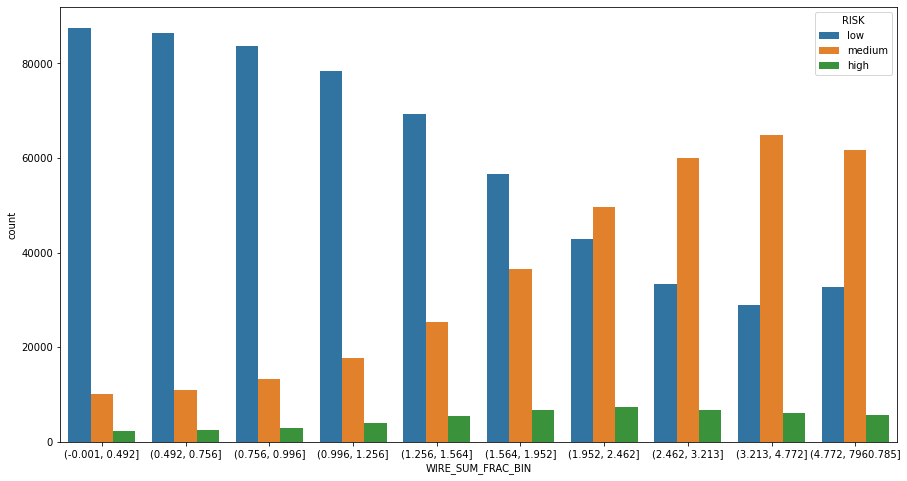

In [14]:
plt.figure(figsize=(15, 8))
sns.countplot(x='WIRE_SUM_FRAC_BIN', hue='RISK', data=temp)
plt.show()

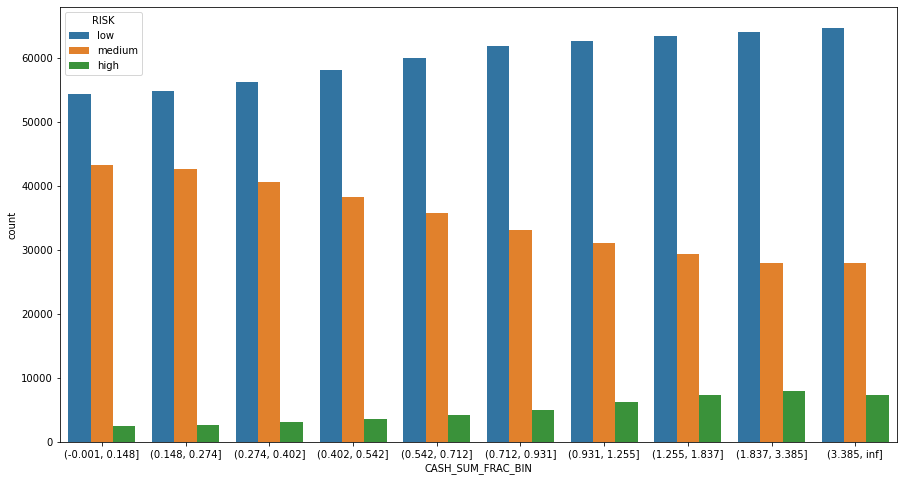

In [17]:
plt.figure(figsize=(15, 8))
sns.countplot(x='CASH_SUM_FRAC_BIN', hue='RISK', data=temp)
plt.show()

### Binning effect on the CNT_IN and OUT features

#### CASH_CNT_IN

In [69]:
nodes['CASH_CNT_IN_BINS'] = pd.qcut(nodes['CASH_CNT_IN'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

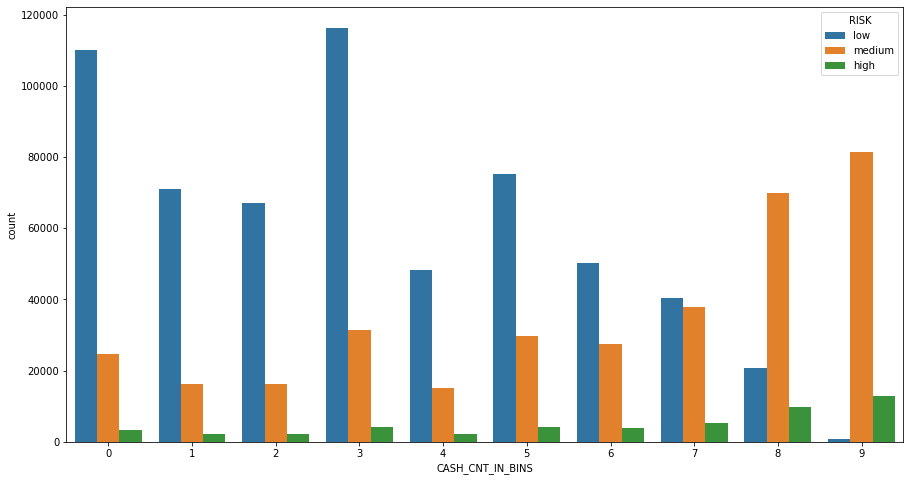

In [70]:
plt.figure(figsize=(15, 8))
sns.countplot(x='CASH_CNT_IN_BINS', hue='RISK', data=nodes)
plt.show()

#### CASH_CNT_OUT

In [71]:
nodes['CASH_CNT_OUT_BINS'] = pd.qcut(nodes['CASH_CNT_OUT'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

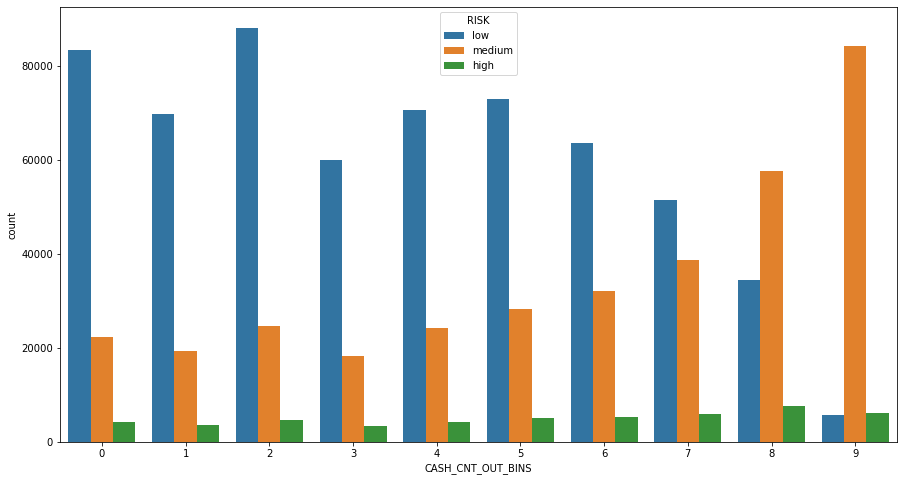

In [72]:
plt.figure(figsize=(15, 8))
sns.countplot(x='CASH_CNT_OUT_BINS', hue='RISK', data=nodes)
plt.show()

#### WIRE_CNT_IN

In [73]:
nodes['WIRES_CNT_IN_BINS'] = pd.qcut(nodes['WIRES_CNT_IN'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

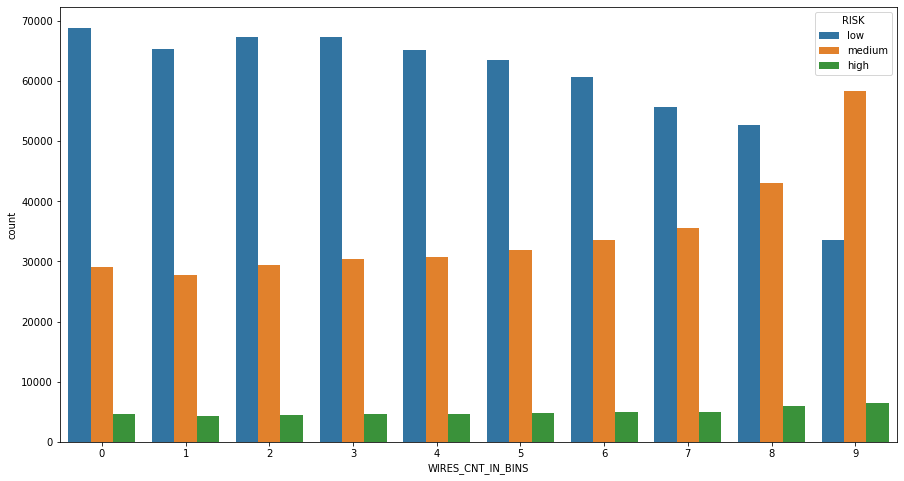

In [74]:
plt.figure(figsize=(15, 8))
sns.countplot(x='WIRES_CNT_IN_BINS', hue='RISK', data=nodes)
plt.show()

#### WIRE_CNT_OUT

In [75]:
nodes['WIRES_CNT_OUT_BINS'] = pd.qcut(nodes['WIRES_CNT_OUT'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

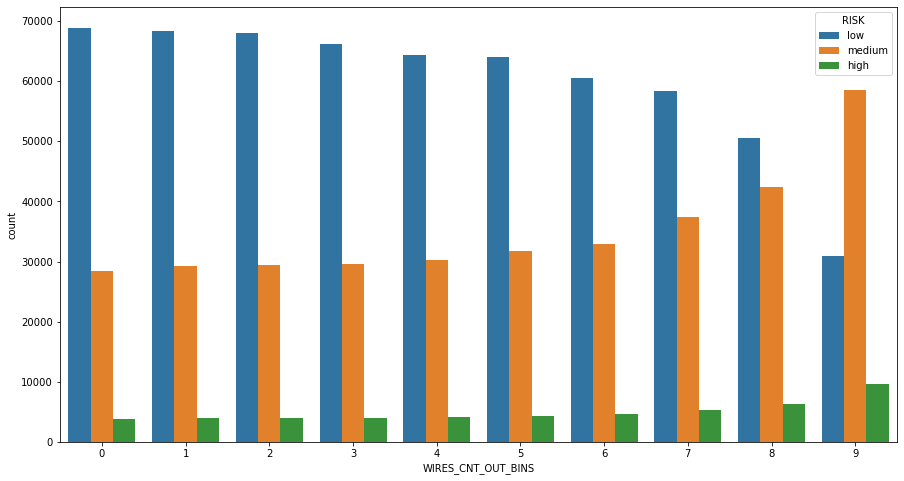

In [76]:
plt.figure(figsize=(15, 8))
sns.countplot(x='WIRES_CNT_OUT_BINS', hue='RISK', data=nodes)
plt.show()

## Modelling workflow

* **STRATIFY**:Imbalanced problem, hence we will have to first stratify our splits!
* **IMPUTATION**: Missing value imputations.
* **FEATURE ENGINEERING / DATA PROCESSING**:After imputation we have to feature engineering/data processing.
* **UPSAMPLING**:Then we will have to check which one of upsampling/smote/class weighting works better.
* in this problem we will have to show alot of plots which tells why some models are working better than the others, show how generalizability is more in some plots and less in some other plots.

In [56]:
nodes = pd.read_csv('UofT_nodes.csv')
occupation_risk = pd.read_csv('UofT_occupation_risk.csv').set_index('code')['occupation_risk']

nodes['OCPTN_RISK'] = nodes['OCPTN_NM'].map(occupation_risk)

nodes['BIRTH_DT'] = pd.to_datetime(nodes['BIRTH_DT'])
nodes['CUST_ADD_DT'] = pd.to_datetime(nodes['CUST_ADD_DT'])

nodes['CUST_YEARS'] = 2022 - nodes['CUST_ADD_DT'].dt.year
nodes['AGE'] = 2022 - nodes['BIRTH_DT'].dt.year

# df_edges = pd.read_csv('UofT_edges.csv')
# graph_nodes = list(set(np.hstack([df_edges['source'].values, df_edges['target'].values])))
# nodes = nodes[nodes['CUSTOMER_ID'].isin(graph_nodes)]

imputer = SimpleImputer(strategy='most_frequent')
nodes = pd.DataFrame(imputer.fit_transform(nodes), columns=nodes.columns)

emb = EmbeddingEncoder(task="classification")
embeddings = emb.fit_transform(nodes['OCPTN_NM'].values.reshape(-1,1), nodes['RISK'].map({'low':0, 'medium':1, 'high':2}).values)

nodes = pd.concat([nodes, pd.DataFrame(embeddings, columns=[f'emb_{i+1}' for i in range(embeddings.shape[1])])], axis=1).sample(frac=1)

In [252]:
df_edges = pd.read_csv('UofT_edges.csv')
graph_nodes = list(set(np.hstack([df_edges['source'].values, df_edges['target'].values])))
nodes = nodes[nodes['CUSTOMER_ID'].isin(graph_nodes)]

In [115]:
nodes.to_csv('nodes_data_full.csv', index=False)

In [5]:
nodes = pd.read_csv('nodes_data_full.csv')

In [420]:
_ = nodes_full.sample(frac=1)
nodes_small, _ = train_test_split(_, train_size=0.3, stratify=_['RISK'])

In [421]:
nodes = nodes_small

# Upsampling

In [273]:
_ = nodes.sample(frac=1)
nodes_small, _ = train_test_split(_, train_size=0.03, stratify=_['RISK'])

In [274]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT',
            'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 
            'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE'] + [f'emb_{i+1}' for i in range(embeddings.shape[1])]
cat_ohe_cols = ['PEP_FL', 'OCPTN_RISK']
cat_non_ohe_cols = []
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes_small[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

# for col in cat_non_ohe_cols:
#     imputer = SimpleImputer(strategy='most_frequent')
#     data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))
    
fold_dict_small = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols, 
             n_folds=2)

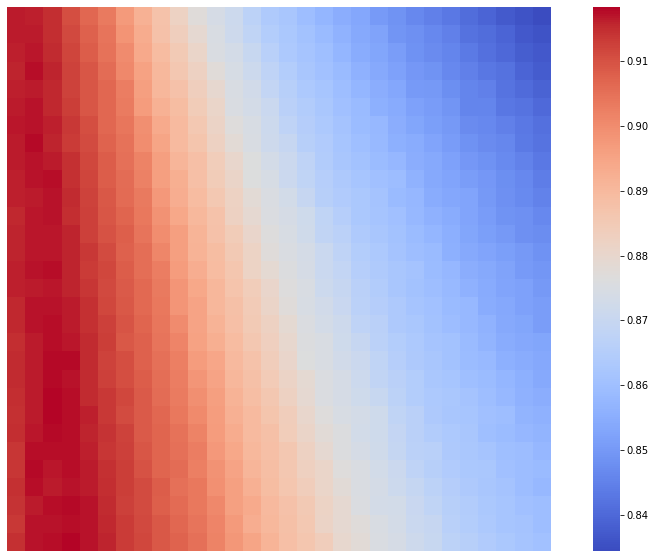

In [158]:
plt.figure(figsize=(15, 10))
sns.heatmap(upsample_df_mcc, cmap='coolwarm',
            yticklabels=False, xticklabels=False, cbar=True, square=True)

plt.yticks(range(20), labels=[np.round(i, 2) for i in np.linspace(1, class_weights[1], 20)], fontsize=14)
plt.xticks(range(20), labels=[np.round(i, 2) for i in np.linspace(1, class_weights[2], 20)], fontsize=14)
plt.show()

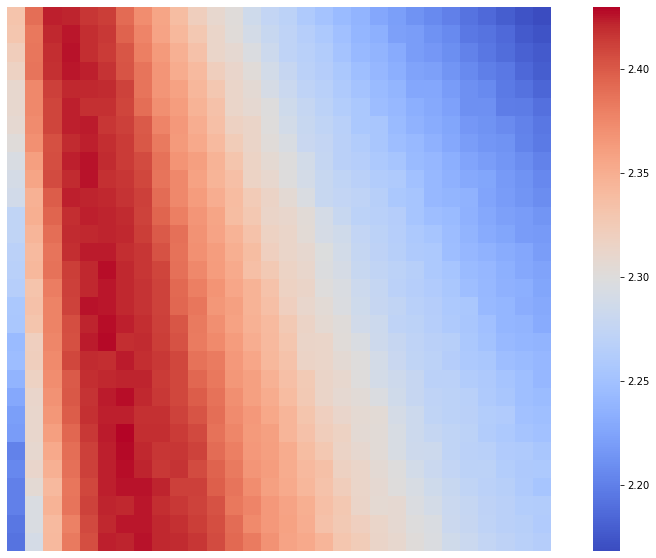

In [159]:
plt.figure(figsize=(15, 10))
sns.heatmap(upsample_df_high+upsample_df_medium+upsample_df_mcc, cmap='coolwarm',
            yticklabels=False, xticklabels=False, cbar=True, square=True)

# plt.yticks(range(30), labels=[np.round(i, 2) for i in np.linspace(1, class_weights[1], 30)], fontsize=14)
# plt.xticks(range(30), labels=[np.round(i, 2) for i in np.linspace(1, class_weights[2], 30)], fontsize=14)
plt.show()

# Modelling

In [6]:
imbalanced_results = dict()
balanced_results = dict()
logreg_dict = dict()
folds = 5

In [7]:
nodes = nodes.sample(frac=1)

### LogisticRegression

#### Imbalanced

In [219]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT',
            'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 
            'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE'] + [f'emb_{i+1}' for i in range(embeddings.shape[1])]
cat_ohe_cols = ['PEP_FL', 'OCPTN_RISK']
cat_non_ohe_cols = []
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

# for col in cat_non_ohe_cols:
#     imputer = SimpleImputer(strategy='most_frequent')
#     data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))
    
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols, 
             n_folds=folds)
#popped = fold_dict.pop(f'fold_{len(fold_dict)}', None)
# kwargs = {'early_stopping_rounds':50, 
#           'cat_features':[fold_dict['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
#           'verbose':0}
model = LogisticRegression()
results = run_model(model, fold_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.76s/it]


In [220]:
imbalanced_results['logreg'] = results
logreg_dict['imbalanced'] = results
results

,train,val,test
low,0.999239,0.999255,0.999244
medium,0.940684,0.940939,0.940741
high,0.448588,0.451574,0.448847
mcc,0.915859,0.916252,0.915942


#### Balanced

In [266]:
classes = np.unique(fold_dict['fold_1'][3].to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][3])
class_weights = dict(zip(classes, weights))

In [222]:
#class_weights = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}
model = LogisticRegression(class_weight=class_weights)
results = run_model(model, fold_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:27<00:00, 17.46s/it]


In [223]:
balanced_results['logreg'] = results
logreg_dict['balanced'] = results
results

,train,val,test
low,0.999442,0.999405,0.999417
medium,0.876264,0.877543,0.876516
high,0.526883,0.528364,0.526841
mcc,0.860020,0.861006,0.860146


#### balanced better class weights

In [224]:
class_weights = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}

In [225]:
model = LogisticRegression(class_weight=class_weights)
results = run_model(model, fold_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.46s/it]


In [226]:
balanced_results['logreg'] = results
logreg_dict['balanced_better_weights'] = results
results

,train,val,test
low,0.999401,0.999392,0.999396
medium,0.931467,0.931935,0.931431
high,0.552892,0.554858,0.552592
mcc,0.907469,0.908054,0.907411


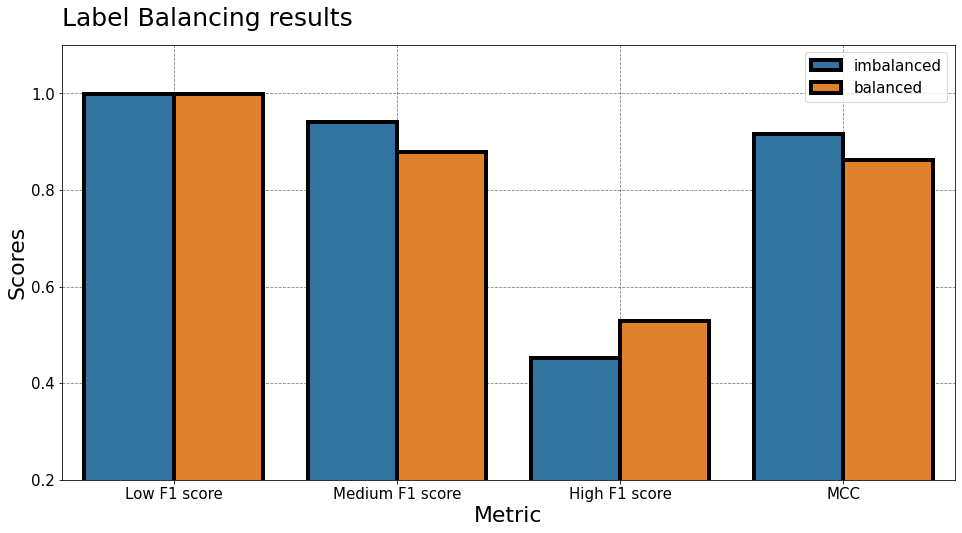

In [248]:
results_tot = get_weight_total_results(logreg_dict)
results_tot = results_tot[results_tot['split'] == 'val']
results_tot = results_tot[results_tot['case'] != 'balanced_better_weights']

plt.figure(figsize=(16, 8))

sns.barplot(x='index', y='scores', hue='case', data=results_tot[results_tot['split'] == 'val'], edgecolor='k', linewidth=4, zorder=4)
plt.xlabel('Metric', fontsize=22)
plt.ylabel('Scores', fontsize=22)
plt.title('Label Balancing results', fontsize=25, loc='left', y=1.03)
plt.xticks([0, 1, 2, 3], labels=['Low F1 score', 'Medium F1 score', 'High F1 score', 'MCC'], fontsize=15)
plt.yticks(fontsize=15)#, ticks=[i*10 for i in range(0, 10)], labels=[f'{i*10}%' for i in range(0, 10)] )

plt.grid(alpha=0.5, color='k', linestyle='--')
plt.legend(fontsize=15, loc='upper right')
plt.axis([-0.5, 3.5, 0.2, 1.1])
plt.show()

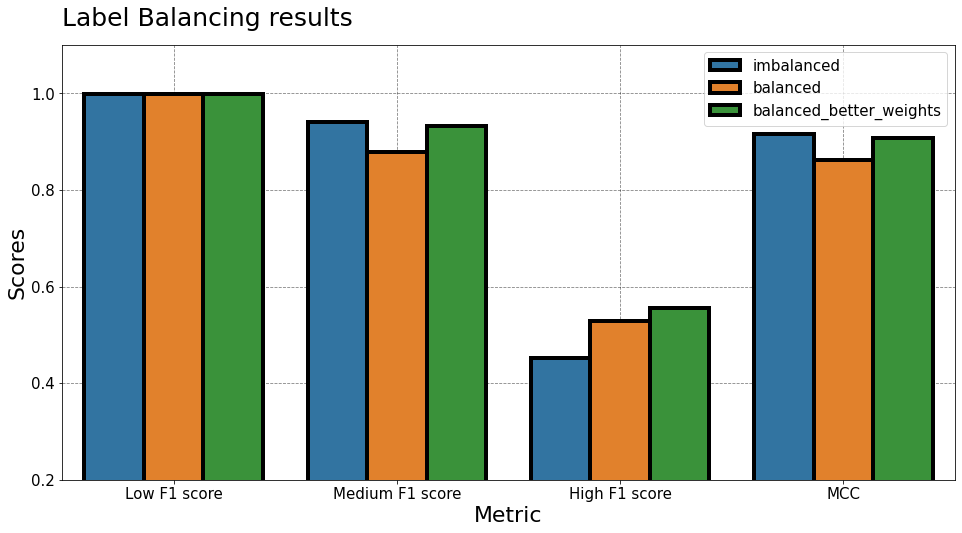

In [249]:
results_tot = get_weight_total_results(logreg_dict)

plt.figure(figsize=(16, 8))

sns.barplot(x='index', y='scores', hue='case', data=results_tot[results_tot['split'] == 'val'], edgecolor='k', linewidth=4, zorder=4)
plt.xlabel('Metric', fontsize=22)
plt.ylabel('Scores', fontsize=22)
plt.title('Label Balancing results', fontsize=25, loc='left', y=1.03)
plt.xticks([0, 1, 2, 3], labels=['Low F1 score', 'Medium F1 score', 'High F1 score', 'MCC'], fontsize=15)
plt.yticks(fontsize=15)#, ticks=[i*10 for i in range(0, 10)], labels=[f'{i*10}%' for i in range(0, 10)] )

plt.grid(alpha=0.5, color='k', linestyle='--')
plt.legend(fontsize=15)
plt.axis([-0.5, 3.5, 0.2, 1.1])
plt.show()


### LightGBM

In [166]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT',
            'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 
            'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']
cat_ohe_cols = []
cat_non_ohe_cols = ['OCPTN_NM', 'PEP_FL', 'OCPTN_RISK']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

# for col in cat_non_ohe_cols:
#     imputer = SimpleImputer(strategy='most_frequent')
#     data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))
    
fold_dict_cat = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols, 
             n_folds=folds)

#### Imbalanced

In [ ]:
kwargs = {'early_stopping_rounds':20, 
          'categorical_feature':[fold_dict_cat['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
model =  LGBMClassifier(n_estimators=200000, n_jobs=-1)
results = run_model(model, fold_dict_cat, kwargs=kwargs)

In [ ]:
imbalanced_results['lgbm'] = results
results

#### Balanced

In [363]:
classes = np.unique(fold_dict['fold_1'][3].to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][3])
class_weights = dict(zip(classes, weights))

In [167]:
class_weights = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}
kwargs = {'early_stopping_rounds':20, 
          'categorical_feature':[fold_dict_cat['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
model =  LGBMClassifier(n_estimators=200000, n_jobs=-1, class_weight=class_weights)
results = run_model(model, fold_dict_cat, kwargs=kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:54<00:00, 22.81s/it]


In [168]:
balanced_results['lgbm'] = results
results

,train,val,test
low,0.999945,0.999639,0.999644
medium,0.947125,0.940464,0.940549
high,0.673381,0.629387,0.630093
mcc,0.929980,0.920608,0.920745


### Catboost

#### Imbalanced

In [ ]:
# popped = fold_dict.pop(f'fold_{len(fold_dict)}', None)
kwargs = {'early_stopping_rounds':100, 
          'cat_features':[fold_dict_cat['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU")
results = run_model(cat, fold_dict_cat, kwargs=kwargs)

In [ ]:
imbalanced_results['catboost'] = results
results

#### Balanced

In [377]:
classes = np.unique(fold_dict['fold_1'][3].to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][3])
class_weights = dict(zip(classes, weights))

In [169]:
class_weights = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}
kwargs = {'early_stopping_rounds':100, 
          'cat_features':[fold_dict_cat['fold_1'][0].shape[1]-i for i in range(1, len(cat_non_ohe_cols))],
          'verbose':0}
cat = CatBoostClassifier(task_type="GPU", class_weights=class_weights)
results = run_model(cat, fold_dict_cat, kwargs=kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:29<00:00, 17.88s/it]


In [170]:
balanced_results['catboost'] = results
results

,train,val,test
low,0.999782,0.999678,0.999690
medium,0.951811,0.942838,0.942357
high,0.699244,0.641100,0.638516
mcc,0.935842,0.923663,0.923056


In [171]:
mcc_compare = get_results_list('mcc', balanced_results)
high_compare = get_results_list('high', balanced_results)

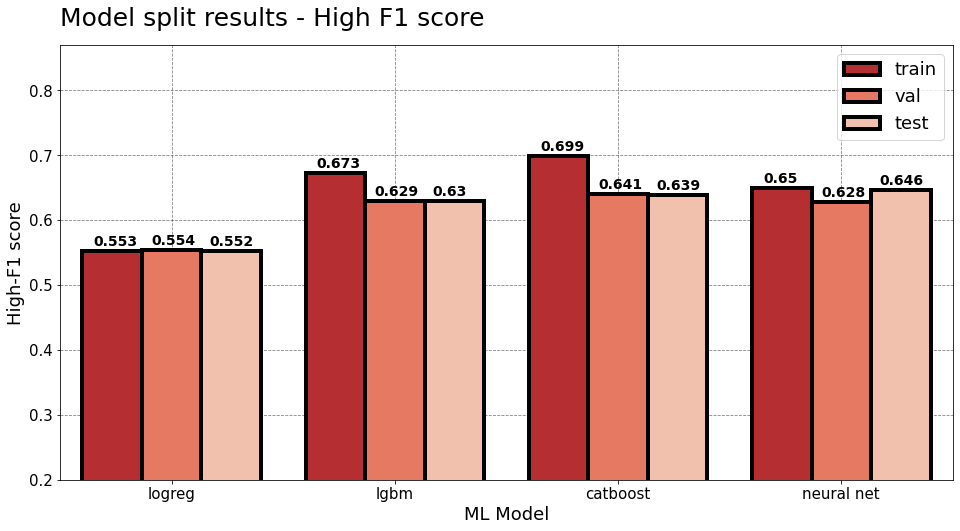

In [8]:
plt.figure(figsize=(16, 8))

sns.barplot(x='model', y='score', hue='split', data=high_compare, edgecolor='k', linewidth=4, zorder=4, palette='Reds_r')
plt.xlabel('ML Model', fontsize=18)
plt.ylabel('High-F1 score', fontsize=18)
plt.title('Model split results - High F1 score', fontsize=25, loc='left', y=1.03)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)#, ticks=[i*10 for i in range(0, 10)], labels=[f'{i*10}%' for i in range(0, 10)] )
for i, label in enumerate(['logreg', 'lgbm', 'catboost', 'neural net']):
    temp2 = high_compare[high_compare['model'] == label]
    k = 0
    for j, val in enumerate(temp2['score']):
        plt.text(i-0.35+k*1.3, val+0.008, f'{np.round(val, 3)}', weight='bold', fontsize=14, color='k')
        k += 0.2

plt.grid(alpha=0.5, color='k', linestyle='--')
plt.legend(fontsize=18)
plt.axis([-0.5, 3.5, 0.2, .87])
plt.show()

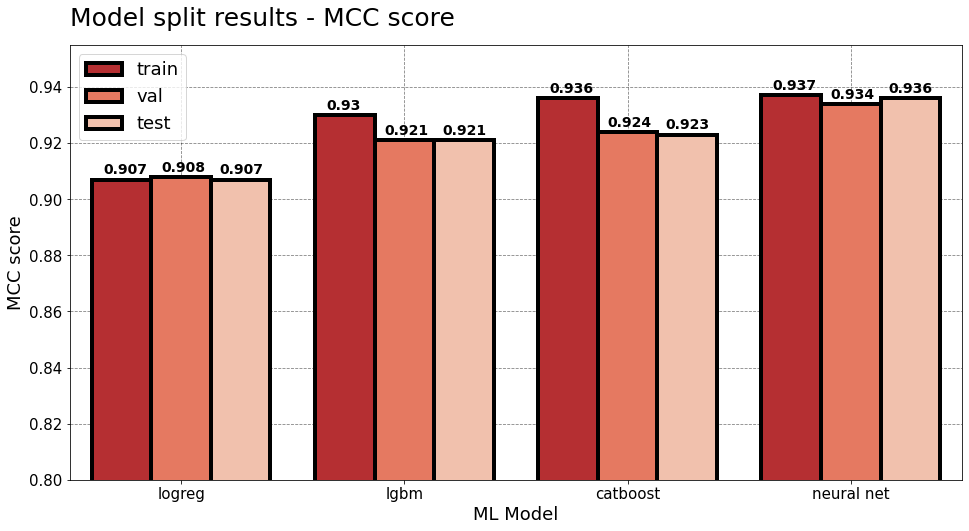

In [10]:
plt.figure(figsize=(16, 8))

sns.barplot(x='model', y='score', hue='split', data=mcc_compare, edgecolor='k', linewidth=4, zorder=4, palette='Reds_r')
plt.xlabel('ML Model', fontsize=18)
plt.ylabel('MCC score', fontsize=18)
plt.title('Model split results - MCC score', fontsize=25, loc='left', y=1.03)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)#, ticks=[i*10 for i in range(0, 10)], labels=[f'{i*10}%' for i in range(0, 10)] )
for i, label in enumerate(['logreg', 'lgbm', 'catboost', 'neural net']):
    temp2 = mcc_compare[mcc_compare['model'] == label]
    k = 0
    for j, val in enumerate(temp2['score']):
        plt.text(i-0.35+k*1.3, val+0.002, f'{np.round(val, 3)}', weight='bold', fontsize=14, color='k')
        k += 0.2

plt.grid(alpha=0.5, color='k', linestyle='--')
plt.legend(fontsize=18)
plt.axis([-0.5, 3.5, 0.8, 0.955])
plt.show()

### Visualizing the data

In [15]:
cols_to_visualize = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT',
       'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT',
       'CUST_YEARS', 'AGE', 'PEP_FL_0.0', 'PEP_FL_1.0',
       'OCPTN_RISK_High', 'OCPTN_RISK_Low', 'OCPTN_RISK_Moderate']
X = fold_dict['fold_1'][0][cols_to_visualize]

In [16]:
pca = PCA()
pca.fit(X)

PCA()

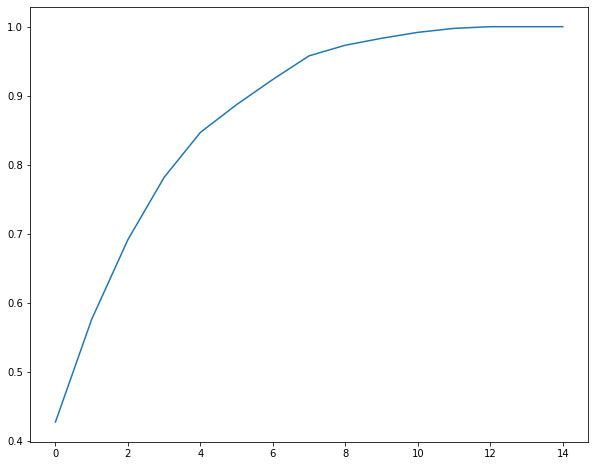

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [18]:
pca = PCA(n_components=11)
X_pca  =pca.fit_transform(X)

In [20]:
x = np.vstack([X_pca[fold_dict['fold_1'][3]==0][:10000], X_pca[fold_dict['fold_1'][3]==1][:10000], X_pca[fold_dict['fold_1'][3]==2][:10000]])
y = np.hstack([fold_dict['fold_1'][3][fold_dict['fold_1'][3]==0][:10000], fold_dict['fold_1'][3][fold_dict['fold_1'][3]==1][:10000], fold_dict['fold_1'][3][fold_dict['fold_1'][3]==2][:10000]])

tsne = TSNE()
X_train_tsne = tsne.fit_transform(x)

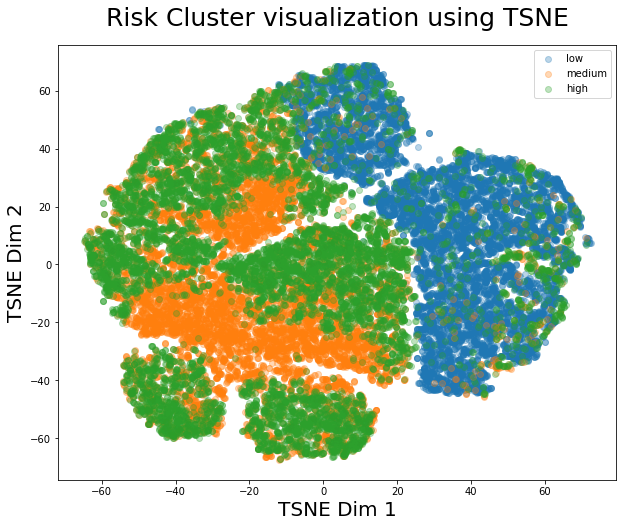

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[y==0][:, 0], X_train_tsne[y==0][:, 1], label='low', alpha=0.3)
plt.scatter(X_train_tsne[y==1][:, 0], X_train_tsne[y==1][:, 1], label='medium', alpha=0.3)
plt.scatter(X_train_tsne[y==2][:, 0], X_train_tsne[y==2][:, 1], label='high', alpha=0.3)
plt.xlabel('TSNE Dim 1', fontsize=20)
plt.ylabel('TSNE Dim 2', fontsize=20)
plt.title('Risk Cluster visualization using TSNE', fontsize=25, y=1.03)
plt.legend()
plt.show()

# CODE DUMP

In [240]:
import optuna

In [241]:
def objective(trial):
    global fold_dict_cat
    params = {'max_depth':trial.suggest_int('max_depth', 5, 50),
              'n_estimators':200000,
              #'boosting':trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
              'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
              'colsample_bytree':trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
              'learning_rate':trial.suggest_uniform('learning_rate', 0.007, 0.02),
              'reg_lambda':trial.suggest_uniform('reg_lambda', 0.01, 50),
              'reg_alpha':trial.suggest_uniform('reg_alpha', 0.01, 50),
              'min_child_samples':trial.suggest_int('min_child_samples', 5, 100),
              'num_leaves':trial.suggest_int('num_leaves', 10, 200),
              'n_jobs' : -1,
              'max_bin':trial.suggest_int('max_bin', 300, 1000),
              'cat_smooth':trial.suggest_int('cat_smooth', 5, 100),
              'cat_l2':trial.suggest_loguniform('cat_l2', 1e-3, 100),
              'class_weight':class_weights}

    kwargs = {'early_stopping_rounds':20, 
          'categorical_feature':[10, 11, 12],
          'verbose':0}

    model =  LGBMClassifier(**params)
    results = run_model(model, fold_dict_cat, kwargs=kwargs)
    overfit = results.loc['mcc', 'train'] - results.loc['mcc', 'val']
    f1 = results.loc['medium', 'val'] + results.loc['high', 'val'] 
    print(f'overfit : {overfit} || f1 score total : {f1}')
                  
    return overfit, f1

In [242]:
study = optuna.create_study(directions=["minimize", "maximize"])
study.optimize(objective, n_trials=100)

[I 2023-02-24 17:22:17,540] A new study created in memory with name: no-name-b7c6a2b0-6744-4d30-ae78-c2580c40e484
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:26<00:00, 21.52s/it]
[I 2023-02-24 17:23:43,738] Trial 0 finished with values: [0.06803890391789902, 1.5424042152165525] and parameters: {'max_depth': 43, 'subsample': 0.5404442445586267, 'colsample_bytree': 0.4787355252045192, 'learning_rate': 0.015969825170056413, 'reg_lambda': 8.421935838790777, 'reg_alpha': 6.687587129038275, 'min_child_samples': 91, 'num_leaves': 190, 'max_bin': 761, 'cat_smooth': 81, 'cat_l2': 17.99311479332376}. 


overfit : 0.06803890391789902 || f1 score total : 1.5424042152165525


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.93s/it]
[I 2023-02-24 17:24:47,457] Trial 1 finished with values: [0.018350002966378565, 1.482962581446509] and parameters: {'max_depth': 30, 'subsample': 0.478794331150122, 'colsample_bytree': 0.6104267702820163, 'learning_rate': 0.008657350635501139, 'reg_lambda': 21.933396633223886, 'reg_alpha': 40.52591271000601, 'min_child_samples': 82, 'num_leaves': 198, 'max_bin': 996, 'cat_smooth': 18, 'cat_l2': 0.0018046270135782512}. 


overfit : 0.018350002966378565 || f1 score total : 1.482962581446509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.41s/it]
[I 2023-02-24 17:26:37,140] Trial 2 finished with values: [0.04514416404563104, 1.529117698071841] and parameters: {'max_depth': 22, 'subsample': 0.7292837321202295, 'colsample_bytree': 0.7624638094364709, 'learning_rate': 0.009795427365059044, 'reg_lambda': 42.723125319125515, 'reg_alpha': 18.343432311904376, 'min_child_samples': 39, 'num_leaves': 42, 'max_bin': 543, 'cat_smooth': 17, 'cat_l2': 0.10731778429374489}. 


overfit : 0.04514416404563104 || f1 score total : 1.529117698071841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.50s/it]
[I 2023-02-24 17:27:15,155] Trial 3 finished with values: [0.021820412909035802, 1.4815036872571739] and parameters: {'max_depth': 29, 'subsample': 0.7930279744294406, 'colsample_bytree': 0.8562825638240741, 'learning_rate': 0.013094463497000264, 'reg_lambda': 37.43980884487661, 'reg_alpha': 39.611340807024895, 'min_child_samples': 44, 'num_leaves': 20, 'max_bin': 783, 'cat_smooth': 11, 'cat_l2': 0.3706679232184451}. 


overfit : 0.021820412909035802 || f1 score total : 1.4815036872571739


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.08s/it]
[I 2023-02-24 17:29:03,505] Trial 4 finished with values: [0.05228739811670513, 1.5364980624985556] and parameters: {'max_depth': 37, 'subsample': 0.8204288658067012, 'colsample_bytree': 0.7558566833344893, 'learning_rate': 0.014587859317632453, 'reg_lambda': 22.968194245264783, 'reg_alpha': 13.515075302506858, 'min_child_samples': 70, 'num_leaves': 194, 'max_bin': 907, 'cat_smooth': 99, 'cat_l2': 0.005429155063237084}. 


overfit : 0.05228739811670513 || f1 score total : 1.5364980624985556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:02<00:00, 15.65s/it]
[I 2023-02-24 17:30:06,128] Trial 5 finished with values: [0.07348268027788907, 1.5313042771562388] and parameters: {'max_depth': 11, 'subsample': 0.4634179404916373, 'colsample_bytree': 0.7806650623841775, 'learning_rate': 0.01683592093724885, 'reg_lambda': 1.3857675603830042, 'reg_alpha': 6.664739282063337, 'min_child_samples': 40, 'num_leaves': 128, 'max_bin': 473, 'cat_smooth': 60, 'cat_l2': 0.0037601037469779308}. 


overfit : 0.07348268027788907 || f1 score total : 1.5313042771562388


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:09<00:00, 32.41s/it]
[I 2023-02-24 17:32:15,822] Trial 6 finished with values: [0.06497749410510845, 1.53709806072469] and parameters: {'max_depth': 47, 'subsample': 0.700029074699716, 'colsample_bytree': 0.40503976970946126, 'learning_rate': 0.015323109704000394, 'reg_lambda': 32.64007564602002, 'reg_alpha': 6.699893494789915, 'min_child_samples': 96, 'num_leaves': 111, 'max_bin': 906, 'cat_smooth': 74, 'cat_l2': 19.40194926077356}. 


overfit : 0.06497749410510845 || f1 score total : 1.53709806072469


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:42<00:00, 25.67s/it]
[I 2023-02-24 17:33:58,522] Trial 7 finished with values: [0.02811590744020709, 1.5078779711428019] and parameters: {'max_depth': 44, 'subsample': 0.9238176139769112, 'colsample_bytree': 0.20663946732635052, 'learning_rate': 0.013218727912504908, 'reg_lambda': 23.50606499766753, 'reg_alpha': 18.924248357121737, 'min_child_samples': 87, 'num_leaves': 27, 'max_bin': 970, 'cat_smooth': 38, 'cat_l2': 0.02242344823813252}. 


overfit : 0.02811590744020709 || f1 score total : 1.5078779711428019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.38s/it]
[I 2023-02-24 17:34:36,047] Trial 8 finished with values: [0.011812211158401809, 1.4752196204343788] and parameters: {'max_depth': 37, 'subsample': 0.21006804857266861, 'colsample_bytree': 0.6218611153319837, 'learning_rate': 0.0194824072141484, 'reg_lambda': 20.617778148676543, 'reg_alpha': 46.19205707593129, 'min_child_samples': 46, 'num_leaves': 67, 'max_bin': 960, 'cat_smooth': 60, 'cat_l2': 25.094978704788335}. 


overfit : 0.011812211158401809 || f1 score total : 1.4752196204343788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.11s/it]
[I 2023-02-24 17:35:12,492] Trial 9 finished with values: [0.018044987516988242, 1.4843268168951231] and parameters: {'max_depth': 22, 'subsample': 0.2539352907852502, 'colsample_bytree': 0.8214684595170683, 'learning_rate': 0.017393105965232337, 'reg_lambda': 41.9766471309948, 'reg_alpha': 44.9252358469408, 'min_child_samples': 12, 'num_leaves': 141, 'max_bin': 573, 'cat_smooth': 47, 'cat_l2': 37.99044575747947}. 


overfit : 0.018044987516988242 || f1 score total : 1.4843268168951231


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.92s/it]
[I 2023-02-24 17:36:00,173] Trial 10 finished with values: [0.017300890299009164, 1.489021834697716] and parameters: {'max_depth': 16, 'subsample': 0.37025410845244355, 'colsample_bytree': 0.5513113379927834, 'learning_rate': 0.012713246933541518, 'reg_lambda': 42.946103651757554, 'reg_alpha': 34.563496009149276, 'min_child_samples': 49, 'num_leaves': 28, 'max_bin': 394, 'cat_smooth': 47, 'cat_l2': 0.44934076490701763}. 


overfit : 0.017300890299009164 || f1 score total : 1.489021834697716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:15<00:00, 33.98s/it]
[I 2023-02-24 17:38:16,099] Trial 11 finished with values: [0.0750092029398638, 1.5373101215396863] and parameters: {'max_depth': 32, 'subsample': 0.9731239815846477, 'colsample_bytree': 0.6038236668224869, 'learning_rate': 0.011244181196979204, 'reg_lambda': 30.897783207404064, 'reg_alpha': 2.9884689922402243, 'min_child_samples': 89, 'num_leaves': 73, 'max_bin': 889, 'cat_smooth': 71, 'cat_l2': 0.0011350217483334839}. 


overfit : 0.0750092029398638 || f1 score total : 1.5373101215396863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:40<00:00, 10.22s/it]
[I 2023-02-24 17:38:56,985] Trial 12 finished with values: [0.016243581227994963, 1.4816333038908485] and parameters: {'max_depth': 34, 'subsample': 0.48652399157699416, 'colsample_bytree': 0.3229877246858158, 'learning_rate': 0.01996625785496923, 'reg_lambda': 12.31677892724477, 'reg_alpha': 23.880155884635144, 'min_child_samples': 72, 'num_leaves': 13, 'max_bin': 765, 'cat_smooth': 86, 'cat_l2': 0.029082456153584284}. 


overfit : 0.016243581227994963 || f1 score total : 1.4816333038908485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:32<00:00,  8.11s/it]
[I 2023-02-24 17:39:29,421] Trial 13 finished with values: [0.022191140952139032, 1.4847294730337652] and parameters: {'max_depth': 40, 'subsample': 0.6255301712992278, 'colsample_bytree': 0.6024056709792645, 'learning_rate': 0.014538828704221329, 'reg_lambda': 22.592790002501175, 'reg_alpha': 40.4879338966516, 'min_child_samples': 10, 'num_leaves': 154, 'max_bin': 370, 'cat_smooth': 12, 'cat_l2': 12.499996474116227}. 


overfit : 0.022191140952139032 || f1 score total : 1.4847294730337652


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:32<00:00, 38.10s/it]
[I 2023-02-24 17:42:01,867] Trial 14 finished with values: [0.06741181820124553, 1.5292532771238103] and parameters: {'max_depth': 30, 'subsample': 0.7940525827565719, 'colsample_bytree': 0.9950508717895401, 'learning_rate': 0.010510195879057157, 'reg_lambda': 41.239359258338936, 'reg_alpha': 10.145782388033659, 'min_child_samples': 5, 'num_leaves': 182, 'max_bin': 627, 'cat_smooth': 42, 'cat_l2': 2.41002129576953}. 


overfit : 0.06741181820124553 || f1 score total : 1.5292532771238103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:15<00:00, 19.00s/it]
[I 2023-02-24 17:43:17,885] Trial 15 finished with values: [0.04865300111672177, 1.5362506909157694] and parameters: {'max_depth': 36, 'subsample': 0.6570359207581846, 'colsample_bytree': 0.5614793952062325, 'learning_rate': 0.01861481831872232, 'reg_lambda': 46.81822173744182, 'reg_alpha': 13.093547860673288, 'min_child_samples': 57, 'num_leaves': 85, 'max_bin': 496, 'cat_smooth': 93, 'cat_l2': 21.123219392100662}. 


overfit : 0.04865300111672177 || f1 score total : 1.5362506909157694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:34<00:00, 38.61s/it]
[I 2023-02-24 17:45:52,387] Trial 16 finished with values: [0.07241963450562006, 1.5400675957712733] and parameters: {'max_depth': 50, 'subsample': 0.9691569425569493, 'colsample_bytree': 0.5072836071804719, 'learning_rate': 0.010506481795923929, 'reg_lambda': 27.3375990567737, 'reg_alpha': 5.865046601221405, 'min_child_samples': 7, 'num_leaves': 103, 'max_bin': 449, 'cat_smooth': 52, 'cat_l2': 0.004972336998139879}. 


overfit : 0.07241963450562006 || f1 score total : 1.5400675957712733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:03<00:00, 30.80s/it]
[I 2023-02-24 17:47:55,629] Trial 17 finished with values: [0.06611017876259684, 1.5386960179282103] and parameters: {'max_depth': 48, 'subsample': 0.7818375378158331, 'colsample_bytree': 0.5419066217929631, 'learning_rate': 0.016465795268318328, 'reg_lambda': 42.525552733768386, 'reg_alpha': 7.577111211841389, 'min_child_samples': 56, 'num_leaves': 94, 'max_bin': 483, 'cat_smooth': 87, 'cat_l2': 4.581605152908771}. 


overfit : 0.06611017876259684 || f1 score total : 1.5386960179282103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:58<00:00, 29.71s/it]
[I 2023-02-24 17:49:54,484] Trial 18 finished with values: [0.021016167729147717, 1.4906435847426436] and parameters: {'max_depth': 47, 'subsample': 0.379196265640974, 'colsample_bytree': 0.21735558093800356, 'learning_rate': 0.008742436620260065, 'reg_lambda': 3.093704301132799, 'reg_alpha': 22.859274110563632, 'min_child_samples': 38, 'num_leaves': 33, 'max_bin': 677, 'cat_smooth': 97, 'cat_l2': 0.4058610426111528}. 


overfit : 0.021016167729147717 || f1 score total : 1.4906435847426436


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:09<00:00, 32.33s/it]
[I 2023-02-24 17:52:03,849] Trial 19 finished with values: [0.04818923660841612, 1.5336363822234458] and parameters: {'max_depth': 45, 'subsample': 0.5305320290422336, 'colsample_bytree': 0.375207108572015, 'learning_rate': 0.01320173568701043, 'reg_lambda': 46.578676352641956, 'reg_alpha': 13.334328429818838, 'min_child_samples': 55, 'num_leaves': 139, 'max_bin': 445, 'cat_smooth': 41, 'cat_l2': 0.0025457929299640917}. 


overfit : 0.04818923660841612 || f1 score total : 1.5336363822234458


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:20<00:00, 35.17s/it]
[I 2023-02-24 17:54:24,573] Trial 20 finished with values: [0.06129277605904293, 1.5402310285402052] and parameters: {'max_depth': 21, 'subsample': 0.579569351166116, 'colsample_bytree': 0.3754033570478919, 'learning_rate': 0.015271626553176404, 'reg_lambda': 44.06862909819035, 'reg_alpha': 4.735808874860252, 'min_child_samples': 7, 'num_leaves': 25, 'max_bin': 556, 'cat_smooth': 66, 'cat_l2': 0.15819368269066078}. 


overfit : 0.06129277605904293 || f1 score total : 1.5402310285402052


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.10s/it]
[I 2023-02-24 17:55:21,053] Trial 21 finished with values: [0.020269430950851652, 1.4797691744940258] and parameters: {'max_depth': 21, 'subsample': 0.3767902691871736, 'colsample_bytree': 0.2883609593443752, 'learning_rate': 0.018699520838195125, 'reg_lambda': 9.026768873462343, 'reg_alpha': 30.19565765689421, 'min_child_samples': 60, 'num_leaves': 88, 'max_bin': 882, 'cat_smooth': 19, 'cat_l2': 0.1208622440691049}. 


overfit : 0.020269430950851652 || f1 score total : 1.4797691744940258


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.63s/it]
[I 2023-02-24 17:56:07,600] Trial 22 finished with values: [0.018940550559261582, 1.4841390761673994] and parameters: {'max_depth': 47, 'subsample': 0.4411189337907887, 'colsample_bytree': 0.5824740113810318, 'learning_rate': 0.014464177917350989, 'reg_lambda': 34.61456714328221, 'reg_alpha': 40.83366814371971, 'min_child_samples': 21, 'num_leaves': 121, 'max_bin': 405, 'cat_smooth': 28, 'cat_l2': 6.806889555495875}. 


overfit : 0.018940550559261582 || f1 score total : 1.4841390761673994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:35<00:00, 23.85s/it]
[I 2023-02-24 17:57:42,995] Trial 23 finished with values: [0.07909361914857127, 1.529006404849874] and parameters: {'max_depth': 42, 'subsample': 0.2344164190819008, 'colsample_bytree': 0.3485548069407768, 'learning_rate': 0.014691774164838448, 'reg_lambda': 17.961787770489174, 'reg_alpha': 2.225231574713937, 'min_child_samples': 76, 'num_leaves': 90, 'max_bin': 715, 'cat_smooth': 15, 'cat_l2': 0.3788427504923115}. 


overfit : 0.07909361914857127 || f1 score total : 1.529006404849874


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.76s/it]
[I 2023-02-24 17:58:46,044] Trial 24 finished with values: [0.051952553879674235, 1.532547906881497] and parameters: {'max_depth': 14, 'subsample': 0.9945698418447741, 'colsample_bytree': 0.9491323295314285, 'learning_rate': 0.01583847911754639, 'reg_lambda': 3.5979061135438375, 'reg_alpha': 15.645864296147998, 'min_child_samples': 67, 'num_leaves': 149, 'max_bin': 921, 'cat_smooth': 44, 'cat_l2': 23.981863873170703}. 


overfit : 0.051952553879674235 || f1 score total : 1.532547906881497


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:15<00:00, 33.85s/it]
[I 2023-02-24 18:01:01,450] Trial 25 finished with values: [0.07541531137010737, 1.5322367091838627] and parameters: {'max_depth': 42, 'subsample': 0.21406947319396938, 'colsample_bytree': 0.838104716968002, 'learning_rate': 0.007947651867931007, 'reg_lambda': 15.231602310563206, 'reg_alpha': 2.724966716768934, 'min_child_samples': 33, 'num_leaves': 60, 'max_bin': 708, 'cat_smooth': 60, 'cat_l2': 75.21985532021763}. 


overfit : 0.07541531137010737 || f1 score total : 1.5322367091838627


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.44s/it]
[I 2023-02-24 18:01:47,217] Trial 26 finished with values: [0.013667397418989813, 1.4792204381993268] and parameters: {'max_depth': 50, 'subsample': 0.6305294413886232, 'colsample_bytree': 0.6552692812712195, 'learning_rate': 0.013567045394813185, 'reg_lambda': 30.347655037112844, 'reg_alpha': 43.07938023756173, 'min_child_samples': 93, 'num_leaves': 63, 'max_bin': 497, 'cat_smooth': 52, 'cat_l2': 2.9432385643743135}. 


overfit : 0.013667397418989813 || f1 score total : 1.4792204381993268


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.85s/it]
[I 2023-02-24 18:02:38,610] Trial 27 finished with values: [0.013728778271788422, 1.4795603876383643] and parameters: {'max_depth': 7, 'subsample': 0.9219573091535842, 'colsample_bytree': 0.7239129196235021, 'learning_rate': 0.018082412319837243, 'reg_lambda': 34.509885275441036, 'reg_alpha': 43.315360679046044, 'min_child_samples': 49, 'num_leaves': 126, 'max_bin': 338, 'cat_smooth': 51, 'cat_l2': 0.013134231667211475}. 


overfit : 0.013728778271788422 || f1 score total : 1.4795603876383643


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:20<00:00, 20.19s/it]
[I 2023-02-24 18:03:59,399] Trial 28 finished with values: [0.030585018729394786, 1.5187342390360188] and parameters: {'max_depth': 47, 'subsample': 0.29160521719501564, 'colsample_bytree': 0.36290524432249116, 'learning_rate': 0.01538924339035248, 'reg_lambda': 49.74891680129171, 'reg_alpha': 18.55731679731859, 'min_child_samples': 68, 'num_leaves': 24, 'max_bin': 721, 'cat_smooth': 56, 'cat_l2': 0.0955408536990864}. 


overfit : 0.030585018729394786 || f1 score total : 1.5187342390360188


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:54<00:00, 28.56s/it]
[I 2023-02-24 18:05:53,660] Trial 29 finished with values: [0.07686685800459503, 1.529470968987629] and parameters: {'max_depth': 31, 'subsample': 0.5029144016144693, 'colsample_bytree': 0.46990880102145005, 'learning_rate': 0.016951038674551566, 'reg_lambda': 32.739796281154234, 'reg_alpha': 4.197571616678496, 'min_child_samples': 28, 'num_leaves': 177, 'max_bin': 555, 'cat_smooth': 83, 'cat_l2': 96.43710802939323}. 


overfit : 0.07686685800459503 || f1 score total : 1.529470968987629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:35<00:00, 23.76s/it]
[I 2023-02-24 18:07:28,717] Trial 30 finished with values: [0.07621841058845269, 1.5179892181912429] and parameters: {'max_depth': 46, 'subsample': 0.7334660839672373, 'colsample_bytree': 0.34283810536544945, 'learning_rate': 0.01652291471193098, 'reg_lambda': 15.192150854533379, 'reg_alpha': 4.0359009886081605, 'min_child_samples': 72, 'num_leaves': 119, 'max_bin': 318, 'cat_smooth': 21, 'cat_l2': 1.8286479953605776}. 


overfit : 0.07621841058845269 || f1 score total : 1.5179892181912429


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:31<00:00,  7.87s/it]
[I 2023-02-24 18:08:00,225] Trial 31 finished with values: [0.016972166555691004, 1.4823699379163653] and parameters: {'max_depth': 12, 'subsample': 0.6138731664358522, 'colsample_bytree': 0.3528176005286896, 'learning_rate': 0.019116465039998354, 'reg_lambda': 17.180755370408498, 'reg_alpha': 32.86132755337902, 'min_child_samples': 53, 'num_leaves': 60, 'max_bin': 809, 'cat_smooth': 64, 'cat_l2': 0.3446765690592407}. 


overfit : 0.016972166555691004 || f1 score total : 1.4823699379163653


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:09<00:00, 17.37s/it]
[I 2023-02-24 18:09:09,712] Trial 32 finished with values: [0.008086280936053125, 1.4403547740013374] and parameters: {'max_depth': 13, 'subsample': 0.9095028946742632, 'colsample_bytree': 0.2359014298164885, 'learning_rate': 0.00838491635220966, 'reg_lambda': 33.24181695619803, 'reg_alpha': 46.80772266284455, 'min_child_samples': 62, 'num_leaves': 49, 'max_bin': 739, 'cat_smooth': 63, 'cat_l2': 0.4076148074778942}. 


overfit : 0.008086280936053125 || f1 score total : 1.4403547740013374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.34s/it]
[I 2023-02-24 18:10:07,160] Trial 33 finished with values: [0.01688353137330445, 1.4884442648858252] and parameters: {'max_depth': 39, 'subsample': 0.37015622554814087, 'colsample_bytree': 0.868076097240666, 'learning_rate': 0.010905354219441473, 'reg_lambda': 33.82600188765126, 'reg_alpha': 41.55793680155433, 'min_child_samples': 17, 'num_leaves': 158, 'max_bin': 436, 'cat_smooth': 89, 'cat_l2': 0.06659090733629183}. 


overfit : 0.01688353137330445 || f1 score total : 1.4884442648858252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:19<00:00, 19.88s/it]
[I 2023-02-24 18:11:26,726] Trial 34 finished with values: [0.05906689542200638, 1.5358235035381806] and parameters: {'max_depth': 8, 'subsample': 0.35247591294915215, 'colsample_bytree': 0.8484273116724264, 'learning_rate': 0.014597636677571631, 'reg_lambda': 9.261681229545415, 'reg_alpha': 12.368307778635339, 'min_child_samples': 20, 'num_leaves': 175, 'max_bin': 931, 'cat_smooth': 41, 'cat_l2': 0.016496918042274548}. 


overfit : 0.05906689542200638 || f1 score total : 1.5358235035381806


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:30<00:00, 37.74s/it]
[I 2023-02-24 18:13:57,723] Trial 35 finished with values: [0.04899771291946409, 1.5413778362950308] and parameters: {'max_depth': 7, 'subsample': 0.35452127720493637, 'colsample_bytree': 0.5158845948671807, 'learning_rate': 0.008573020608013111, 'reg_lambda': 34.525388150306455, 'reg_alpha': 12.621516702137225, 'min_child_samples': 12, 'num_leaves': 29, 'max_bin': 792, 'cat_smooth': 27, 'cat_l2': 0.25363749596304536}. 


overfit : 0.04899771291946409 || f1 score total : 1.5413778362950308


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:25<00:00, 21.37s/it]
[I 2023-02-24 18:15:23,241] Trial 36 finished with values: [0.017122614620505683, 1.4859831364776246] and parameters: {'max_depth': 41, 'subsample': 0.4244534794568307, 'colsample_bytree': 0.3759266242369574, 'learning_rate': 0.008258344411766878, 'reg_lambda': 37.78454508252779, 'reg_alpha': 32.82987694805541, 'min_child_samples': 31, 'num_leaves': 131, 'max_bin': 647, 'cat_smooth': 76, 'cat_l2': 13.299870161444211}. 


overfit : 0.017122614620505683 || f1 score total : 1.4859831364776246


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.42s/it]
[I 2023-02-24 18:16:12,945] Trial 37 finished with values: [0.009360673861546709, 1.4559933485782515] and parameters: {'max_depth': 48, 'subsample': 0.6894852859863391, 'colsample_bytree': 0.23587137119820004, 'learning_rate': 0.013098571653616454, 'reg_lambda': 46.90606850860554, 'reg_alpha': 35.92698587357218, 'min_child_samples': 99, 'num_leaves': 11, 'max_bin': 558, 'cat_smooth': 60, 'cat_l2': 0.11631842789945894}. 


overfit : 0.009360673861546709 || f1 score total : 1.4559933485782515


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:12<00:00, 18.04s/it]
[I 2023-02-24 18:17:25,125] Trial 38 finished with values: [0.04949717677976562, 1.5390493258688958] and parameters: {'max_depth': 22, 'subsample': 0.8396295091931159, 'colsample_bytree': 0.8437024408291964, 'learning_rate': 0.015787996494609824, 'reg_lambda': 43.41666973188455, 'reg_alpha': 15.057292259109596, 'min_child_samples': 54, 'num_leaves': 35, 'max_bin': 955, 'cat_smooth': 25, 'cat_l2': 0.08680289864046914}. 


overfit : 0.04949717677976562 || f1 score total : 1.5390493258688958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:21<00:00, 20.29s/it]
[I 2023-02-24 18:18:46,308] Trial 39 finished with values: [0.06239219632711013, 1.530866168085617] and parameters: {'max_depth': 49, 'subsample': 0.20349290717412877, 'colsample_bytree': 0.9848569786717529, 'learning_rate': 0.01420335842448971, 'reg_lambda': 13.63238912324602, 'reg_alpha': 11.494836216854159, 'min_child_samples': 45, 'num_leaves': 181, 'max_bin': 955, 'cat_smooth': 66, 'cat_l2': 0.6059533504218586}. 


overfit : 0.06239219632711013 || f1 score total : 1.530866168085617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.18s/it]
[I 2023-02-24 18:19:31,030] Trial 40 finished with values: [0.024549192629719108, 1.5025282627997845] and parameters: {'max_depth': 6, 'subsample': 0.3748566347457971, 'colsample_bytree': 0.8427866490356932, 'learning_rate': 0.015798656135449986, 'reg_lambda': 35.629748612151616, 'reg_alpha': 28.79132277706746, 'min_child_samples': 44, 'num_leaves': 25, 'max_bin': 404, 'cat_smooth': 41, 'cat_l2': 0.03241738661465994}. 


overfit : 0.024549192629719108 || f1 score total : 1.5025282627997845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.78s/it]
[I 2023-02-24 18:20:38,182] Trial 41 finished with values: [0.04377247913518467, 1.5322955832866985] and parameters: {'max_depth': 23, 'subsample': 0.764602039779523, 'colsample_bytree': 0.4398747988649935, 'learning_rate': 0.013482569474551695, 'reg_lambda': 5.536516697865424, 'reg_alpha': 16.347740165149606, 'min_child_samples': 27, 'num_leaves': 86, 'max_bin': 521, 'cat_smooth': 40, 'cat_l2': 0.008612059847094443}. 


overfit : 0.04377247913518467 || f1 score total : 1.5322955832866985


  0%|                                                                                            | 0/4 [00:06<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-223-64a4f318372b>", line 144, in run_model
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\engine.py", line 299, in train
    evaluation_result_list.extend(booster.eval_valid(feval))
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\basic.py", line 3271, in eval_valid
    return [item for i in range(1, self.__num_dataset)
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\basic.py", line 3272, in <listcomp>
    for item in self.__inner_eval(self.name_valid_sets[i - 1], i, feval)]
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lig

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-223-64a4f318372b>", line 144, in run_model
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\engine.py", line 299, in train
    evaluation_result_list.extend(booster.eval_valid(feval))
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\basic.py", line 3271, in eval_valid
    return [item for i in range(1, self.__num_dataset)
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lightgbm\basic.py", line 3272, in <listcomp>
    for item in self.__inner_eval(self.name_valid_sets[i - 1], i, feval)]
  File "C:\Users\AWWAL\anaconda3\lib\site-packages\lig

TypeError: object of type 'NoneType' has no len()

In [236]:
classes = np.unique(fold_dict['fold_1'][3].to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][3])
class_weights = dict(zip(classes, weights))

### RandomForestClassifier

#### Imbalanced

In [66]:
model = RandomForestClassifier(n_jobs=-1)
results = run_model(model, fold_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:45<00:00, 25.05s/it]


In [67]:
imbalanced_results['rfc'] = results
results

,train,val,test
low,1.000000,0.997848,0.982912
medium,0.999997,0.912907,0.892840
high,0.999993,0.644687,0.532643
mcc,0.999996,0.875126,0.831791


#### Balanced

In [68]:
classes = np.unique(fold_dict['fold_1'][3].to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_dict['fold_1'][3])
class_weights = dict(zip(classes, weights))

In [69]:
model = RandomForestClassifier(n_jobs=-1, class_weight=class_weights)
results = run_model(model, fold_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:36<00:00, 24.04s/it]


In [70]:
balanced_results['rfc'] = results
results

,train,val,test
low,0.999999,0.997831,0.985865
medium,0.999998,0.912613,0.892284
high,0.999989,0.637093,0.510506
mcc,0.999996,0.874402,0.833832


## RFE feature selection

In [160]:
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']#, 'degree', 'closeness_centrality',
           #'subgraph_size', 'sent', 'received', 'node_sg_degree_frac', 'diameter_len_frac', 'money_displaced_len_frac']#, 'subgraphs_avg_money_sent','subgraphs_avg_money_received']
cat_ohe_cols = ['PEP_FL', 'GENDER', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA', 'OCPTN_RISK']
cat_non_ohe_cols = ['OCPTN_NM']
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'CUSTOMER_ID', 'NAME', 'RISK']
data = nodes[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]
fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols,
             model_type='LogisticRegression',
             n_folds=5)
popped = fold_dict.pop(f'fold_{len(fold_dict)}', None)

In [161]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=1, step=1, verbose=1)

rfe.fit(fold_dict['fold_1'][0], fold_dict['fold_1'][3])

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFE(estimator=LogisticRegression(), n_features_to_select=1, verbose=1)

In [164]:
logreg = LogisticRegression()

mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test = feature_drop_scorer(rfe, fold_dict, logreg)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [05:52<00:00, 13.05s/it]


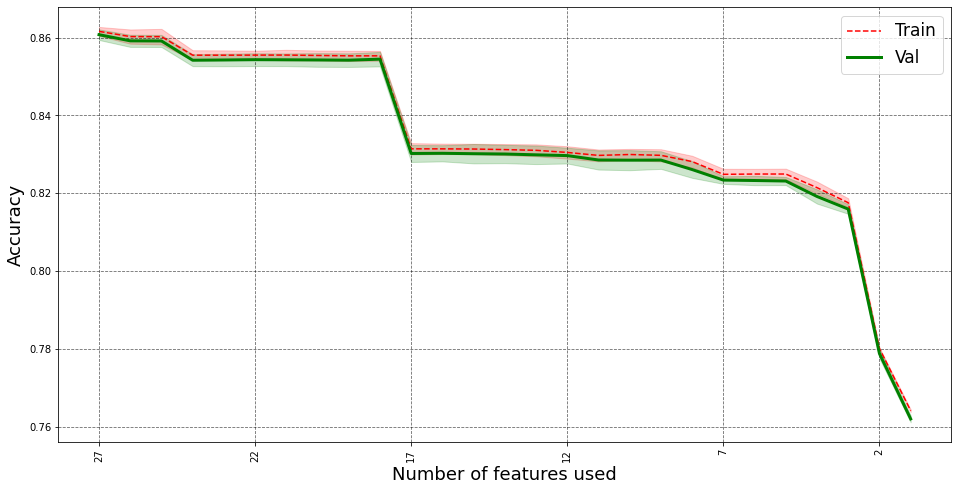

In [166]:
upper_bound_train = np.array(mean_scores_train) + np.array(std_scores_train)
lower_bound_train = np.array(mean_scores_train) - np.array(std_scores_train)
upper_bound_val = np.array(mean_scores_val) + np.array(std_scores_val)
lower_bound_val = np.array(mean_scores_val) - np.array(std_scores_val)

plt.figure(figsize=(16, 8))
plt.plot(mean_scores_train, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(mean_scores_val, label='Val', color='g', linewidth=3)
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.xticks(ticks=range(0, np.unique(rfe.ranking_)[-1], 5), labels=range(len(fold_dict['fold_1'][0].columns), 0, -5), rotation=90)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Number of features used', fontsize=18)
plt.legend(fontsize=17)
plt.show()

In [174]:
for i in range(1, len(rfe.ranking_)+1):
    print(fold_dict['fold_1'][0].loc[:, rfe.ranking_==i].columns[0])

WIRES_SUM_IN
CASH_SUM_OUT
CASH_CNT_OUT
WIRES_SUM_OUT
PEP_FL_1.0
GENDER_Female
GENDER_Male
CASH_SUM_IN
CASH_CNT_IN
CNTRY_OF_INCOME_CA_0
CNTRY_OF_INCOME_CA_1
RES_CNTRY_CA_0
COUNTRY_RISK_RESIDENCY_Low
COUNTRY_RISK_RESIDENCY_High
COUNTRY_RISK_INCOME_High
COUNTRY_RISK_INCOME_Low
RES_CNTRY_CA_1
WIRES_CNT_OUT
OCPTN_RISK_High
OCPTN_RISK_Low
OCPTN_RISK_Moderate
PEP_FL_0.0
WIRES_CNT_IN
COUNTRY_RISK_INCOME_Moderate
CUST_YEARS
COUNTRY_RISK_RESIDENCY_Moderate
AGE


### Binning CNT_IN and OUT features and ordinal encoding

In [80]:
temp = nodes.copy()

# Binning cnt_in and out features
temp['CASH_CNT_IN_BINS'] = pd.qcut(temp['CASH_CNT_IN'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
temp['CASH_CNT_OUT_BINS'] = pd.qcut(temp['CASH_CNT_OUT'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
temp['WIRES_CNT_IN_BINS'] = pd.qcut(temp['WIRES_CNT_IN'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
temp['WIRES_CNT_OUT_BINS'] = pd.qcut(temp['WIRES_CNT_OUT'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                                    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'NAME', 'GENDER', 'CUSTOMER_ID', 'CASH_CNT_IN',
            'CASH_CNT_OUT', 'WIRES_CNT_IN', 'WIRES_CNT_OUT'], axis=1, inplace=True)

# Data Splitting
X = tempdrop('RISK', axis=1)
y = temp['RISK']

target_mapping = {'low':0, 'medium':1, 'high':2}
y = y.map(target_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)


# Data Imputation
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN_BINS', 'CASH_SUM_OUT', 'CASH_CNT_OUT_BINS', 'WIRES_SUM_IN',
       'WIRES_CNT_IN_BINS', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT_BINS', 'CUST_YEARS', 'AGE']
cat_cols = ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY']

imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

numerical_pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler)])
categorical_pipeline = Pipeline(steps=[('ohe', ohe)])

preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, num_cols),
                                               ('cat', categorical_pipeline, cat_cols)],
                                 remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
cat_cols_name = list(preprocessor.transformers_[1][1]['ohe'].get_feature_names(cat_cols))
X_train = pd.DataFrame(X_train, columns=num_cols+cat_cols_name)

X_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=num_cols+cat_cols_name)

cv = StratifiedKFold(n_splits=7).split(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)


#X['CUST_YEARS'].fillna(value=X['CUST_YEARS'].mode()[0], inplace=True)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [88]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_train_preds = logreg.predict(X_train)
y_val_preds = logreg.predict(X_val)
y_test_preds = logreg.predict(X_test)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Findings from binning the out and in features

It seems that not binning them and considering them to be numerical features seems to be yielding best results. Binning them experienced slightly worse result as compared to not binning them in the case of the high risk class in both the balanced and imbalanced case.

## Logistic regression with encoded ocptn_nm (Not out of sample generalizable!!)

In [184]:
temp = nodes.copy()

# Adding ocptn_nm encoding
groupby_df = temp.groupby('OCPTN_NM').apply(lambda x:x['RISK'].value_counts()/len(x))
low_map = groupby_df[:, 'low']
medium_map = groupby_df[:, 'medium']
high_map = groupby_df[:, 'high']

temp['LOW_PROP'] = temp['OCPTN_NM'].map(low_map)
temp['MEDIUM_PROP'] = temp['OCPTN_NM'].map(medium_map)
temp['HIGH_PROP'] = temp['OCPTN_NM'].map(high_map)

temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'OCPTN_NM', 'GENDER', 'CUSTOMER_ID'], axis=1, inplace=True)

# Data Splitting
X = temp.drop('RISK', axis=1)
y = temp['RISK']

target_mapping = {'low':0, 'medium':1, 'high':2}
y = y.map(target_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)


# Data Imputation
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'LOW_PROP', 'MEDIUM_PROP', 'HIGH_PROP']
cat_cols = ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY']

imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

numerical_pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler)])
categorical_pipeline = Pipeline(steps=[('ohe', ohe)])

preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, num_cols),
                                               ('cat', categorical_pipeline, cat_cols)],
                                 remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
cat_cols_name = list(preprocessor.transformers_[1][1]['ohe'].get_feature_names(cat_cols))
X_train = pd.DataFrame(X_train, columns=num_cols+cat_cols_name)

X_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=num_cols+cat_cols_name)

cv = StratifiedKFold(n_splits=7).split(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Imbalanced

In [198]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_train_preds = logreg.predict(X_train)
y_val_preds = logreg.predict(X_val)
y_test_preds = logreg.predict(X_test)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [199]:
get_results(y_train, y_train_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    384000
           1       0.92      0.97      0.94    224000
           2       0.67      0.38      0.49     32000

    accuracy                           0.96    640000
   macro avg       0.86      0.79      0.81    640000
weighted avg       0.95      0.96      0.95    640000


CONFUSION MATRIX : 

[[383996      3      1]
 [   221 217691   6088]
 [   228  19474  12298]]


MCC : 0.9209341754926285


In [200]:
get_results(y_val, y_val_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96000
           1       0.92      0.97      0.94     56000
           2       0.68      0.38      0.49      8000

    accuracy                           0.96    160000
   macro avg       0.86      0.79      0.81    160000
weighted avg       0.95      0.96      0.95    160000


CONFUSION MATRIX : 

[[96000     0     0]
 [   54 54482  1464]
 [   54  4887  3059]]


MCC : 0.9215042222680465


In [201]:
get_results(y_test, y_test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120000
           1       0.92      0.97      0.94     70000
           2       0.66      0.38      0.48     10000

    accuracy                           0.96    200000
   macro avg       0.86      0.78      0.81    200000
weighted avg       0.95      0.96      0.95    200000


CONFUSION MATRIX : 

[[119997      2      1]
 [    87  67912   2001]
 [    87   6083   3830]]


MCC : 0.9196151554875145


### balanced

In [194]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
y_train_preds = logreg.predict(X_train)
y_val_preds = logreg.predict(X_val)
y_test_preds = logreg.predict(X_test)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [195]:
get_results(y_train, y_train_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    384000
           1       0.98      0.81      0.88    224000
           2       0.39      0.88      0.54     32000

    accuracy                           0.93    640000
   macro avg       0.79      0.89      0.81    640000
weighted avg       0.96      0.93      0.94    640000


CONFUSION MATRIX : 

[[383860      0    140]
 [   114 180441  43445]
 [   117   3818  28065]]


MCC : 0.8670876334214097


In [196]:
get_results(y_val, y_val_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96000
           1       0.98      0.81      0.88     56000
           2       0.39      0.88      0.54      8000

    accuracy                           0.93    160000
   macro avg       0.79      0.89      0.81    160000
weighted avg       0.96      0.93      0.94    160000


CONFUSION MATRIX : 

[[95965     0    35]
 [   28 45121 10851]
 [   25   941  7034]]


MCC : 0.8674367028232464


In [197]:
get_results(y_test, y_test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120000
           1       0.98      0.80      0.88     70000
           2       0.39      0.87      0.54     10000

    accuracy                           0.93    200000
   macro avg       0.79      0.89      0.81    200000
weighted avg       0.96      0.93      0.94    200000


CONFUSION MATRIX : 

[[119956      0     44]
 [    48  56324  13628]
 [    39   1239   8722]]


MCC : 0.866033126499115


## Catboost model with ocptn_nm

In [14]:
temp = nodes.copy()


temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID'], axis=1, inplace=True)
temp['OCPTN_NM'] = temp['OCPTN_NM'].fillna(temp['OCPTN_NM'].mode()[0]).astype(int)

# Data Splitting
X = temp.drop('RISK', axis=1)
y = temp['RISK']


target_mapping = {'low':0, 'medium':1, 'high':2}
y = y.map(target_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)


# Data Imputation
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE']
cat_ohe_cols = ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'OCPTN_RISK']
cat_non_ohe_cols = ['OCPTN_NM']

imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

numerical_pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler)])
categorical_pipeline = Pipeline(steps=[('imputer', imputer), ('ohe', ohe)])

preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, num_cols),
                                               ('cat', categorical_pipeline, cat_ohe_cols)],
                                 remainder='passthrough')
X_train = preprocessor.fit_transform(X_train)
cat_cols_name = list(preprocessor.transformers_[1][1]['ohe'].get_feature_names(cat_ohe_cols))
X_train = pd.DataFrame(X_train, columns=num_cols+cat_cols_name+cat_non_ohe_cols)

X_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=num_cols+cat_cols_name+cat_non_ohe_cols)

cv = StratifiedKFold(n_splits=7).split(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

X_train['OCPTN_NM'] = X_train['OCPTN_NM'].astype(int)
X_val['OCPTN_NM'] = X_val['OCPTN_NM'].astype(int)
X_test['OCPTN_NM'] = X_test['OCPTN_NM'].astype(int)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Imbalanced case

In [15]:
cat = CatBoostClassifier(eval_metric="MCC", task_type="GPU")
cat.fit(X_train, y_train, eval_set=[(X_val, y_val)],
          early_stopping_rounds=50, 
          cat_features=[25],
          verbose=100)
y_train_preds = cat.predict(X_train)
y_val_preds = cat.predict(X_val)
y_test_preds = cat.predict(X_test)

Learning rate set to 0.201955
0:	learn: 0.8967214	test: 0.8970672	best: 0.8970672 (0)	total: 19.6ms	remaining: 19.5s
100:	learn: 0.9281929	test: 0.9261424	best: 0.9261424 (100)	total: 1.56s	remaining: 13.9s
200:	learn: 0.9327922	test: 0.9289784	best: 0.9290768 (196)	total: 3.02s	remaining: 12s
300:	learn: 0.9350768	test: 0.9304313	best: 0.9304313 (300)	total: 4.49s	remaining: 10.4s
400:	learn: 0.9369325	test: 0.9308629	best: 0.9309284 (360)	total: 6s	remaining: 8.96s
bestTest = 0.9309284312
bestIteration = 360
Shrink model to first 361 iterations.


In [16]:
get_results(y_train, y_train_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    384000
           1       0.94      0.97      0.95    224000
           2       0.74      0.54      0.62     32000

    accuracy                           0.97    640000
   macro avg       0.89      0.84      0.86    640000
weighted avg       0.96      0.97      0.97    640000


CONFUSION MATRIX : 

[[383998      1      1]
 [   127 217892   5981]
 [   146  14672  17182]]


MCC : 0.9363511227784962


In [17]:
get_results(y_val, y_val_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96000
           1       0.93      0.97      0.95     56000
           2       0.71      0.51      0.59      8000

    accuracy                           0.96    160000
   macro avg       0.88      0.83      0.85    160000
weighted avg       0.96      0.96      0.96    160000


CONFUSION MATRIX : 

[[95998     0     2]
 [   34 54280  1686]
 [   50  3903  4047]]


MCC : 0.9309284312000791


In [18]:
get_results(y_test, y_test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120000
           1       0.93      0.97      0.95     70000
           2       0.70      0.50      0.58     10000

    accuracy                           0.96    200000
   macro avg       0.88      0.82      0.84    200000
weighted avg       0.96      0.96      0.96    200000


CONFUSION MATRIX : 

[[119998      1      1]
 [    53  67775   2172]
 [    55   4942   5003]]


MCC : 0.9296510184317118


#### Balanced case

In [19]:
classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [20]:
cat = CatBoostClassifier(eval_metric="MCC", task_type="GPU", class_weights=class_weights)
cat.fit(X_train, y_train, eval_set=[(X_val, y_val)],
          early_stopping_rounds=50, 
          cat_features=[25],
          verbose=100)
y_train_preds = cat.predict(X_train)
y_val_preds = cat.predict(X_val)
y_test_preds = cat.predict(X_test)

Learning rate set to 0.201955
0:	learn: 0.7668144	test: 0.7605088	best: 0.7605088 (0)	total: 14.5ms	remaining: 14.5s
100:	learn: 0.8689822	test: 0.8589550	best: 0.8589550 (100)	total: 1.45s	remaining: 12.9s
200:	learn: 0.8805908	test: 0.8658041	best: 0.8659233 (198)	total: 2.87s	remaining: 11.4s
300:	learn: 0.8865499	test: 0.8675571	best: 0.8684828 (274)	total: 4.3s	remaining: 9.99s
bestTest = 0.8684828021
bestIteration = 274
Shrink model to first 275 iterations.


In [21]:
get_results(y_train, y_train_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    384000
           1       0.99      0.84      0.91    224000
           2       0.45      0.93      0.61     32000

    accuracy                           0.94    640000
   macro avg       0.81      0.92      0.84    640000
weighted avg       0.97      0.94      0.95    640000


CONFUSION MATRIX : 

[[383965      1     34]
 [   116 187695  36189]
 [    95   2139  29766]]


MCC : 0.8914955442548202


In [22]:
get_results(y_val, y_val_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96000
           1       0.98      0.84      0.90     56000
           2       0.44      0.90      0.59      8000

    accuracy                           0.94    160000
   macro avg       0.81      0.91      0.83    160000
weighted avg       0.97      0.94      0.95    160000


CONFUSION MATRIX : 

[[95989     0    11]
 [   30 46774  9196]
 [   41   755  7204]]


MCC : 0.8867512687711833


In [23]:
get_results(y_test, y_test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120000
           1       0.98      0.83      0.90     70000
           2       0.44      0.90      0.59     10000

    accuracy                           0.94    200000
   macro avg       0.81      0.91      0.83    200000
weighted avg       0.97      0.94      0.95    200000


CONFUSION MATRIX : 

[[119987      1     12]
 [    41  58307  11652]
 [    41    915   9044]]


MCC : 0.885850791097072


### WIRE AND CASH SUM FRAC FEATURE WITH CATBOOST

In [45]:
temp = nodes.copy()

temp['CASH_SUM_OUT'] = temp['CASH_SUM_OUT'].where(temp['CASH_SUM_OUT'] != 0, 0.003)

temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID'], axis=1, inplace=True)
temp['OCPTN_NM'] = temp['OCPTN_NM'].fillna(temp['OCPTN_NM'].mode()[0]).astype(int)
temp['WIRE_SUM_FRAC'] = temp['WIRES_SUM_IN']/temp['WIRES_SUM_OUT']
temp['WIRE_SUM_FRAC_BIN'] = pd.qcut(temp['WIRE_SUM_FRAC'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
temp['CASH_SUM_FRAC'] = temp['CASH_SUM_IN']/temp['CASH_SUM_OUT']
temp['CASH_SUM_FRAC_BIN'] = pd.qcut(temp['CASH_SUM_FRAC'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Data Splitting
X = temp.drop('RISK', axis=1)
y = temp['RISK']


target_mapping = {'low':0, 'medium':1, 'high':2}
y = y.map(target_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)


# Data Imputation
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN',
       'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE', 'WIRE_SUM_FRAC', 'CASH_SUM_FRAC',
           'WIRE_SUM_FRAC_BIN', 'CASH_SUM_FRAC_BIN']
cat_ohe_cols = ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY']
cat_non_ohe_cols = ['OCPTN_NM']

imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

numerical_pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler)])
categorical_pipeline = Pipeline(steps=[('ohe', ohe)])

preprocessor = ColumnTransformer(transformers=[('num', numerical_pipeline, num_cols),
                                               ('cat', categorical_pipeline, cat_ohe_cols)],
                                 remainder='passthrough')
X_train = preprocessor.fit_transform(X_train)
cat_cols_name = list(preprocessor.transformers_[1][1]['ohe'].get_feature_names(cat_ohe_cols))
X_train = pd.DataFrame(X_train, columns=num_cols+cat_cols_name+cat_non_ohe_cols)

X_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=num_cols+cat_cols_name+cat_non_ohe_cols)

cv = StratifiedKFold(n_splits=7).split(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

X_train['OCPTN_NM'] = X_train['OCPTN_NM'].astype(int)
X_val['OCPTN_NM'] = X_val['OCPTN_NM'].astype(int)
X_test['OCPTN_NM'] = X_test['OCPTN_NM'].astype(int)

C:\Users\AWWAL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [47]:
cat = CatBoostClassifier(eval_metric="MCC", task_type="GPU", class_weights=class_weights)
cat.fit(X_train, y_train, eval_set=[(X_val, y_val)],
          early_stopping_rounds=50, 
          cat_features=[24, 25, 26],
          verbose=100)
y_train_preds = cat.predict(X_train)
y_val_preds = cat.predict(X_val)
y_test_preds = cat.predict(X_test)

Learning rate set to 0.201955
0:	learn: 0.7658946	test: 0.7623940	best: 0.7623940 (0)	total: 16ms	remaining: 16s
100:	learn: 0.8673613	test: 0.8608930	best: 0.8608930 (100)	total: 1.48s	remaining: 13.2s
200:	learn: 0.8790555	test: 0.8674533	best: 0.8676010 (174)	total: 2.95s	remaining: 11.7s
300:	learn: 0.8850360	test: 0.8711138	best: 0.8712593 (294)	total: 4.39s	remaining: 10.2s
bestTest = 0.8713952997
bestIteration = 303
Shrink model to first 304 iterations.


In [48]:
get_results(y_train, y_train_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    384000
           1       0.99      0.84      0.91    224000
           2       0.45      0.93      0.61     32000

    accuracy                           0.94    640000
   macro avg       0.81      0.92      0.84    640000
weighted avg       0.97      0.94      0.95    640000


CONFUSION MATRIX : 

[[383963      1     36]
 [   113 187777  36110]
 [    82   2158  29760]]


MCC : 0.8916815207328438


In [49]:
get_results(y_val, y_val_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96000
           1       0.99      0.83      0.90     56000
           2       0.44      0.91      0.59      8000

    accuracy                           0.94    160000
   macro avg       0.81      0.91      0.83    160000
weighted avg       0.97      0.94      0.95    160000


CONFUSION MATRIX : 

[[95995     0     5]
 [   27 46661  9312]
 [   43   694  7263]]


MCC : 0.8864491872961369


In [50]:
get_results(y_test, y_test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120000
           1       0.99      0.83      0.90     70000
           2       0.44      0.91      0.59     10000

    accuracy                           0.94    200000
   macro avg       0.81      0.92      0.83    200000
weighted avg       0.97      0.94      0.95    200000


CONFUSION MATRIX : 

[[119990      0     10]
 [    45  58290  11665]
 [    39    830   9131]]


MCC : 0.8866670663950618
